In [1]:
!pip install d2l

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.9/58.9 kB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 111.7/111.7 kB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 71.2 MB/s eta 0:00:00:00:01:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 72.9 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 82.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.6/62.6 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.4/34.4 MB 49.0 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.3/98.3 kB 6.9 MB/s eta 0:00:00
  Attempting uninstall: requests
    Found existing installation: requests 2.32.3
    Uninstalling requests-2.32.3:
      Successfully uninstalled requests-2.32.3
  Attempting uninstall: pyparsing
    Found existing installation: pyparsing 3.1.2
    Uninstalling pyparsing-3.1.2:
      Successfully uninstalled pyparsing-3.1.2

# Sentiment Analysis and the Dataset

Để phân biệt giữa dữ liệu **review** và **meta** trong hai tập dữ liệu mà bạn đã cung cấp, chúng ta có thể định nghĩa như sau:

 1. **Review Data (Dữ liệu đánh giá)**:
Dữ liệu này thường chứa thông tin phản hồi từ người tiêu dùng về sản phẩm, bao gồm cảm nhận, ý kiến cá nhân, và đánh giá về sản phẩm đó. Trong trường hợp này, các chỉ số có thể bao gồm:
- **#Rating**: Điểm đánh giá trung bình (ví dụ: 4/5 sao).
- **#R_Token**: Số lượng token (từ) trong các đánh giá (ví dụ: tổng số từ trong tất cả các đánh giá).
- **#M_Token**: Số lượng token trong các bình luận (meta comments) liên quan đến đánh giá.

 2. **Meta Data (Dữ liệu meta)**:
Dữ liệu này thường chứa thông tin bổ sung về sản phẩm, chẳng hạn như:
- **Category**: Danh mục sản phẩm (ví dụ: All Beauty, Amazon Fashion).
- **#User**: Số lượng người dùng đã đánh giá hoặc bình luận về sản phẩm.
- **Download**: Thông tin về số lần tải về hoặc tương tác với dữ liệu này.

 Phân tích dữ liệu bạn đã cung cấp:

| Category        | #User   | #Item  | #Rating | #R_Token | #M_Token | Download    |
|-----------------|---------|--------|---------|----------|----------|-------------|
| All_Beauty      | 632.0K  | 112.6K | 701.5K  | 31.6M    | 74.1M    | review, meta|
| Amazon_Fashion   | 2.0M   | 825.9K | 2.5M    | 94.9M    | 510.5M   | review, meta|

- **Dữ liệu cho All_Beauty**:
  - **Review Data**: Có thể xem xét từ **#Rating** (701.5K) và tổng số token trong đánh giá và bình luận (31.6M cho review, 74.1M cho meta).
  
- **Dữ liệu cho Amazon_Fashion**:
  - **Review Data**: Tương tự, các thông tin về đánh giá cũng được cung cấp với **#Rating** (2.5M) và số lượng token.

Tóm lại:
- **Review**: Tập trung vào phản hồi và cảm nhận của người dùng về sản phẩm.
- **Meta**: Cung cấp thông tin về sản phẩm, số lượng người dùng, và các chỉ số khác liên quan đến sản phẩm.

Bạn có thể sử dụng sự phân biệt này để phân tích và xử lý dữ liệu cho các mục đích khác nhau trong nghiên cứu hoặc phát triển sản phẩm.

In [2]:
import os 
import torch 
from torch import nn
from d2l import torch as d2l

In [13]:
import os
import gzip
import json
import requests

d2l.DATA_HUB['Appliances'] = (
    'https://datarepo.eng.ucsd.edu/mcauley_group/data/amazon_2023/raw/review_categories/Appliances.jsonl.gz', 'Unknown') # Added a placeholder for sha1_hash

# Download the dataset
data_dir = d2l.download('Appliances', 'Appliances')

In [4]:
file_path = os.path.join(data_dir) # Specify the filename
print(file_path)
data, labels = [], []

with gzip.open(file_path, 'rt', encoding='utf-8') as f:
    for line in f:
        line = line.strip() # Sử dụng strip để loại bỏ khoảng trắng ở đầu và cuối mỗi dòng
        line = json.loads(line)
        # <giá trị nếu đúng> if <điều kiện> else <giá trị nếu sai>
        labels.append(1 if line['rating'] > 3 else 0)
        data.append(line['text'])


Appliances/Appliances.jsonl.gz


In [20]:
from sklearn.model_selection import train_test_split

def read_amazon(data_dir, is_train):
    data, labels = [], []
    with gzip.open(data_dir, 'rt', encoding='utf-8') as f:
        for line in f:
            line = line.strip() # Sử dụng strip để loại bỏ khoảng trắng ở đầu và cuối mỗi dòng
            line = json.loads(line)
            # <giá trị nếu đúng> if <điều kiện> else <giá trị nếu sai>
            labels.append(1 if line['rating'] > 3 else 0)
            data.append(line['text'])
    data_train, data_test, labels_train, labels_test = train_test_split(data, labels,stratify=labels, test_size=0.2, random_state=42)
    return (data_train, labels_train) if is_train else (data_test, labels_test)

In [6]:
is_train=True
data, labels = read_amazon(data_dir,is_train)

In [7]:
data[:5]

['Ordered this and used for one day and it wouldn’t work anymore. Contacted the seller who did send another one. Same story, used it again for one day and it was not working either. So extremely annoying. It washes well during the less than 24 hours it worked. Reached out to seller again and they refunded the price of the machine.  Finally found one of these that actually worked.  Garatic portable compact mini is great!',
 "Works well with my older gen Kureig. We seem to get more coffee per cup with these than the others we've bought in the past. Will definitely purchase again.",
 'Fit properly.  Works well with my Amana dryer.  Fixed the issue with the dryer belt slipping on the drum.  Dryer works great after installation.',
 'Works great!!  Dryer is warmer than ever, and working wonderfully.  Definitely worth the cost.  Especially if you got your dryer for cheap, like me.  lol.',
 'Works.']

In [8]:
print('# trainings:', len(data))
for x, y in zip(labels[:3], data[:3]):
    print('label:', x, 'review:', y)

# trainings: 1702884
label: 0 review: Ordered this and used for one day and it wouldn’t work anymore. Contacted the seller who did send another one. Same story, used it again for one day and it was not working either. So extremely annoying. It washes well during the less than 24 hours it worked. Reached out to seller again and they refunded the price of the machine.  Finally found one of these that actually worked.  Garatic portable compact mini is great!
label: 1 review: Works well with my older gen Kureig. We seem to get more coffee per cup with these than the others we've bought in the past. Will definitely purchase again.
label: 1 review: Fit properly.  Works well with my Amana dryer.  Fixed the issue with the dryer belt slipping on the drum.  Dryer works great after installation.


In [9]:
train_tokens = d2l.tokenize(data, token='word')
vocab = d2l.Vocab(train_tokens, min_freq=3, reserved_tokens=['<pad>'])

In [10]:
vocab

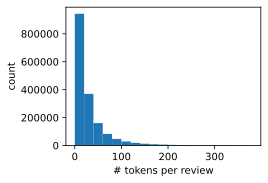

In [11]:
d2l.set_figsize()
d2l.plt.xlabel('# tokens per review')
d2l.plt.ylabel('count')
d2l.plt.hist([len(line) for line in train_tokens], bins=range(0, 400, 20));

In [21]:
def load_data_amazon(batch_size, num_steps=500):
    """Return data iterators and the vocabulary of the IMDb review dataset."""
    data_dir = d2l.download('Appliances', 'Appliances')
    train_data = read_amazon(data_dir, True)# train_data[0] : data, train_data[1] : labels
    test_data = read_amazon(data_dir, False)
    train_tokens = d2l.tokenize(train_data[0], token='word')
    test_tokens = d2l.tokenize(test_data[0], token='word')
    vocab = d2l.Vocab(train_tokens, min_freq=5)
    train_features = torch.tensor([d2l.truncate_pad(
        vocab[line], num_steps, vocab['<pad>']) for line in train_tokens])
    test_features = torch.tensor([d2l.truncate_pad(
        vocab[line], num_steps, vocab['<pad>']) for line in test_tokens])
    train_iter = d2l.load_array((train_features, torch.tensor(train_data[1])),
                                batch_size)
    test_iter = d2l.load_array((test_features, torch.tensor(test_data[1])),
                               batch_size,
                               is_train=False)
    return train_iter, test_iter, vocab

## Sentiment Analysis: Using Recurrent Neural Networks

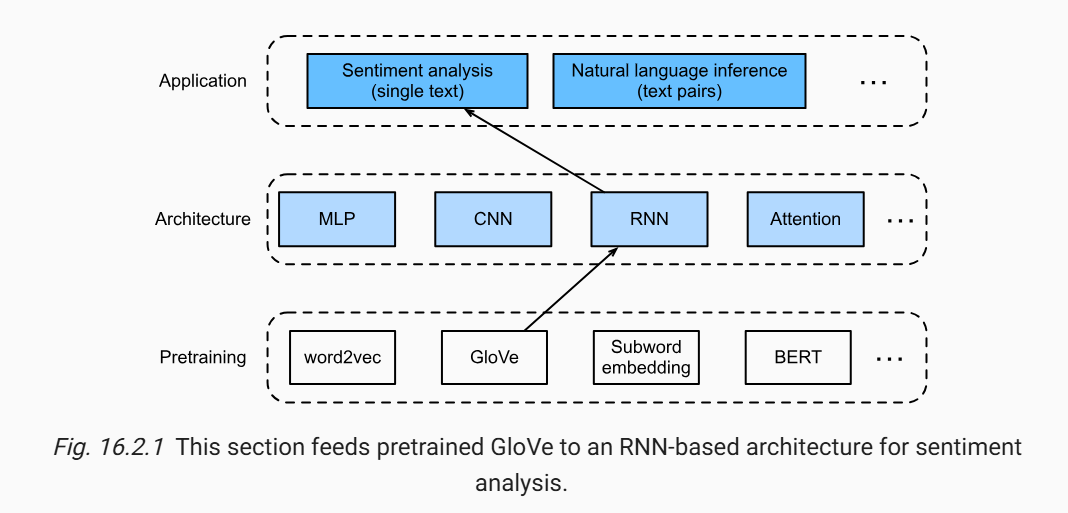

In [ ]:
import torch
from torch import nn
from d2l import torch as d2l

batch_size = 64
train_iter, test_iter, vocab = load_data_amazon(batch_size)

KeyboardInterrupt: 

##  Sentiment Analysis: Using Recurrent Neural Networks

Trong các tác vụ phân loại văn bản, chẳng hạn như phân tích cảm xúc, một chuỗi văn bản có độ dài thay đổi sẽ được chuyển thành các danh mục có độ dài cố định. Trong lớp BiRNN dưới đây, mỗi token của chuỗi văn bản sẽ nhận được biểu diễn GloVe tiền huấn luyện riêng qua lớp embedding (self.embedding), toàn bộ chuỗi được mã hóa bởi một mạng nơ-ron hồi quy hai chiều (BiRNN) (self.encoder). Cụ thể hơn, các trạng thái ẩn (ở lớp cuối cùng) của LSTM hai chiều tại cả hai thời điểm bắt đầu và kết thúc của chuỗi sẽ được nối lại để làm đại diện cho chuỗi văn bản đó. Đại diện văn bản này sau đó được chuyển thành các danh mục đầu ra thông qua một lớp fully connected (self.decoder) với hai đầu ra (“positive” và “negative”).

https://github.com/dvgodoy/dl-visuals/blob/main/Feed-Forward%20Networks/classification.png

Architecture Visual Model

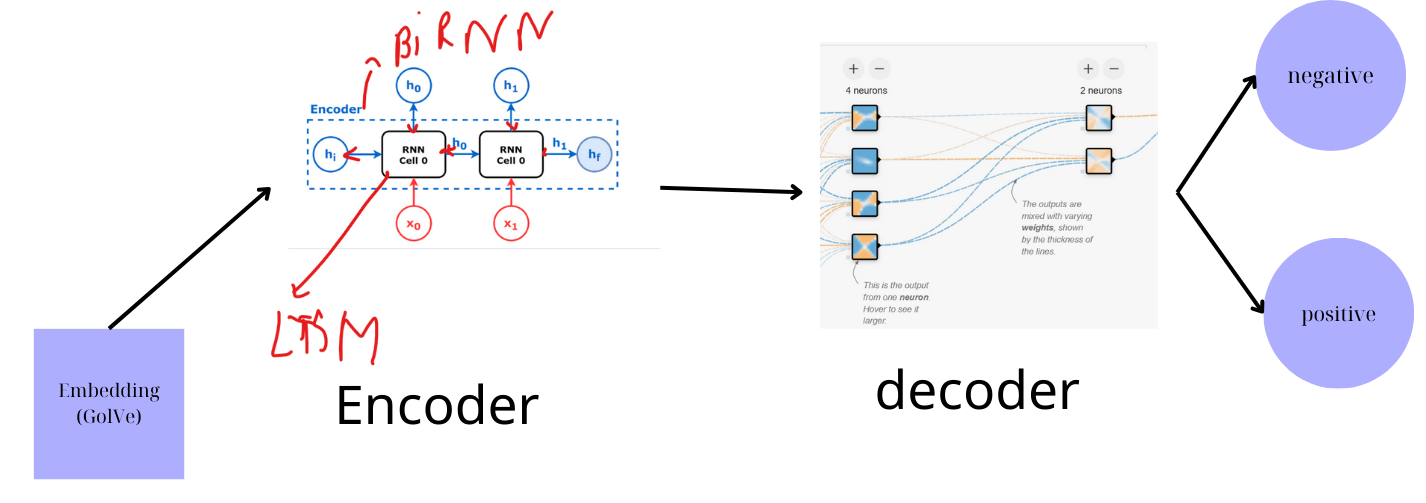

In decoder visualization 4 neurons (with assumption num_hiddens = 1) 

In encoder visualization 2 layer LTSM 

In [ ]:
class BiRNN(nn.Module):
    def __init__(self, vocab_size, embed_size, num_hiddens, num_layers, **kwargs):
        super(BiRNN, self).__init__(**kwargs)
        self.embedding = nn.Embedding(vocab_size, embed_size)
        # Set `bidirectional` to True to get a bidirectional RNN
        self.encoder = nn.LSTM(embed_size, num_hiddens, num_layers=num_layers, bidirectional=True)
        self.decoder = nn.Linear(4 * num_hiddens, 2)
    
    def forward(self, inputs):
        embeddings = self.embedding(inputs.T)
        self.encoder.flatten_parameters()
        
        outputs, _ = self.encoder(embeddings)
        
        encoding = torch.cat((outputs[0], outputs[-1]), dim=1)
        outs = self.decoder(encoding)
        return outs

In [ ]:
embed_size, num_hiddens, num_layers, devices = 100, 100, 2, d2l.try_all_gpus()
net = BiRNN(len(vocab), embed_size, num_hiddens, num_layers)

def init_weights(module):
    if type(module) == nn.Linear: 
        nn.init.xavier_uniform_(module.weight)
    if type(module) == nn.LSTM:
        # Iterate through the parameter of LSTM 
        for param in module._flat_weights_names:
            # Áp dụng khởi tạo Xavier cho trọng số (nhưng không áp dụng độ lệch)
            # apply just for weights (w), not bias (b)
            if "weight" in param:
                nn.init.xavier_uniform_(module._parameters[param])
net.apply(init_weights);

In [ ]:
glove_embedding = d2l.TokenEmbedding('glove.6b.100d')
embeds = glove_embedding[vocab.idx_to_token]
embeds.shape

In [ ]:
net.embedding.weight.data.copy_(embeds)
net.embedding.weight.requires_grad = False


In [ ]:
lr, num_epochs = 0.01, 5
trainer = torch.optim.Adam(net.parameters(), lr=lr)
loss = nn.CrossEntropyLoss(reduction="none")
d2l.train_ch13(net, train_iter, test_iter, loss, trainer, num_epochs, devices)

In [ ]:
#@save
def predict_sentiment(net, vocab, sequence):
    """Predict the sentiment of a text sequence."""
    sequence = torch.tensor(vocab[sequence.split()], device=d2l.try_gpu())
    label = torch.argmax(net(sequence.reshape(1, -1)), dim=1)
    return 'positive' if label == 1 else 'negative'

In [ ]:
predict_sentiment(net, vocab, 'this appliances is so great')

In [ ]:
predict_sentiment(net, vocab, 'this refrigerator refrigerator is so great')

## Sentiment Analysis: Using Convolutional Neural Networks

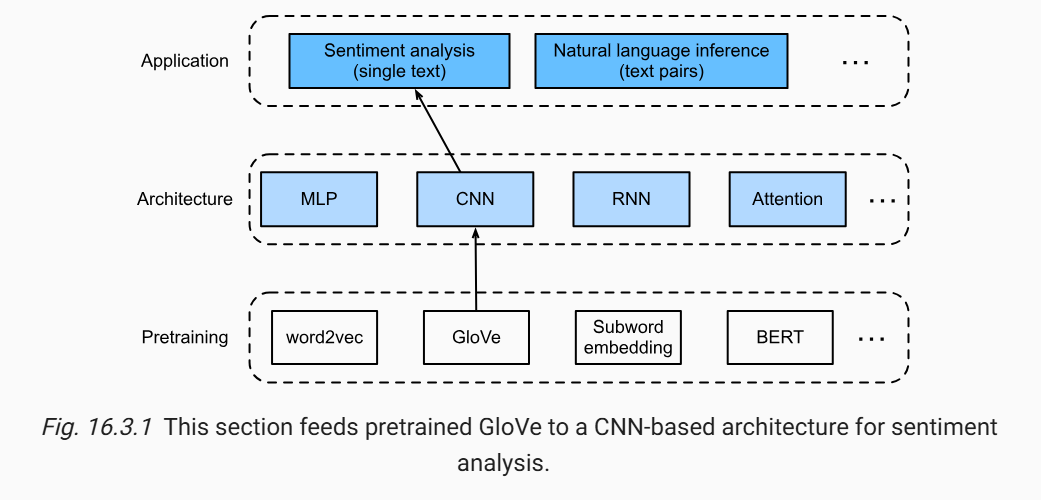

In [2]:
import torch
from torch import d2l
from d2l import torch as d2l

Convolution 

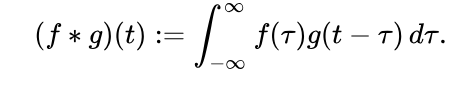

Cross correlation

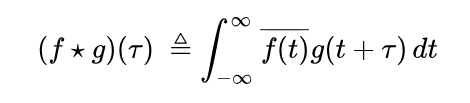

In [10]:
def corr1d(X, K): #  one-dimensional cross-correlation
    # one dimensional convalutions 
    w = K.shape[0] # convalution windown
    Y = torch.zeros((X.shape[0] - w + 1)) # output
    for i in range(Y.shape[0]):
        Y[i] = (X[i: i + w] * K).sum()
    return Y

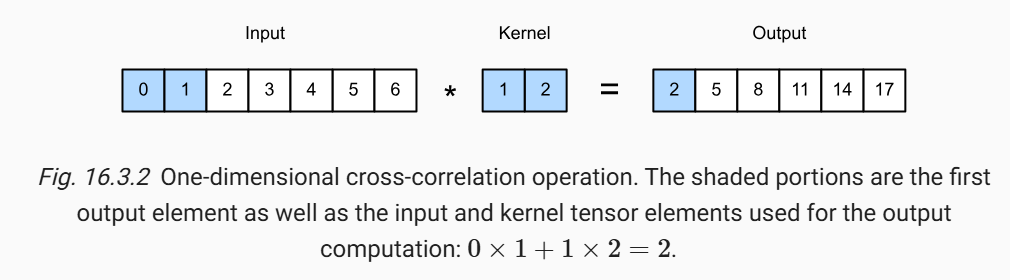

In [13]:
X, K = torch.tensor([0, 1, 2, 3, 4, 5, 6]), torch.tensor([1,2])
corr1d(X, K)

tensor([ 2.,  5.,  8., 11., 14., 17.])

Create one dimensional convolutions equal use 

TextCNN combine between one-dimensional convolution and max-over time long



WHY one-dimensional conv:

How use one-dimensional conv for text CNN

One-dimensional CNNs can process local features such as 𝑛 -grams in text.

In NLP, việc một features có nhiều hơn 1-gram vì vậy nó được sử dụng

Nó hoạt động như thế nào :

Vì trong NLP, 1-gram thường được sử dụng và n-grams thường ít xuất hiện vì vậy việc chuyển từ n-gram thành 1-gram sao cho chúng cùng một kích thước.

One-dimensional conv giúp chuyển từ multi-dimensional sang one-dimensional




Đối với nhiều đầu vào.

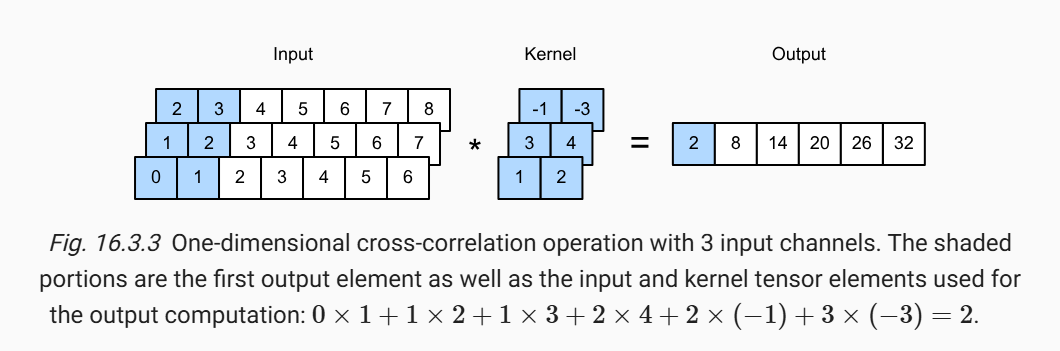

Đối với một đầu vào.
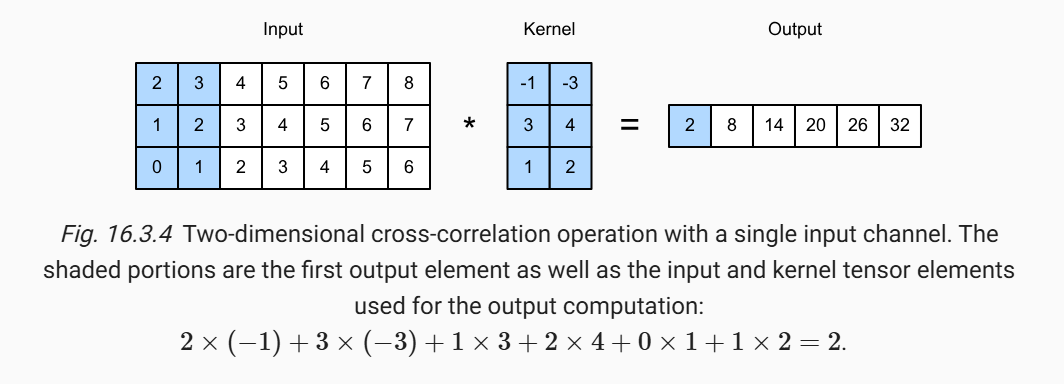

Tại sao sử dụng max-over time pooling 

Cũng giống như max pooling, đặc biệt ở max-over time pooling 

Đối với đầu vào đa kênh trong đó mỗi kênh lưu trữ giá trị ở các bước thời gian khác nhau, đầu ra ở mỗi kênh là giá trị tối đa cho kênh đó. Lưu ý rằng việc gộp tối đa theo thời gian cho phép số lượng bước thời gian khác nhau ở các kênh khác nhau.


Minh họa một max-over time pooling hoạt động
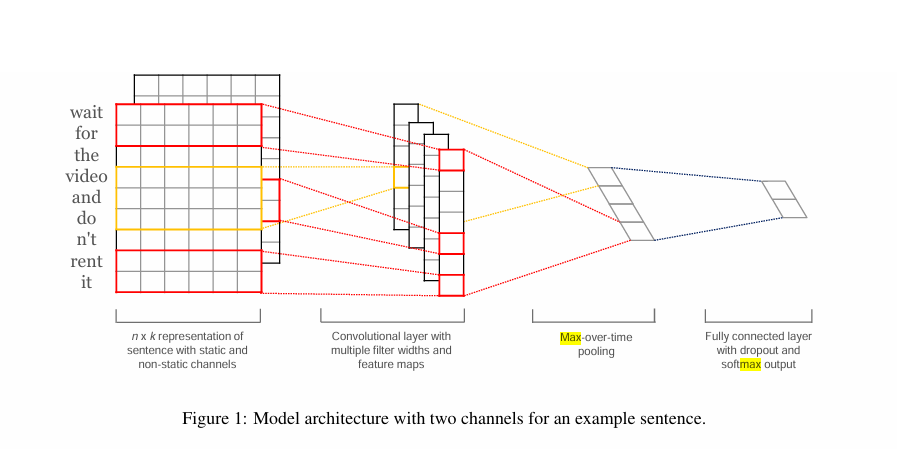

Phép max-over-time pooling thường được áp dụng trong xử lý ngôn ngữ tự nhiên (NLP), khác với phép max-pooling thông thường, phổ biến trong các tác vụ thị giác máy tính (CNN). Cách thiết lập cho NLP có chút khác biệt.

Đầu vào của phép max-over-time pooling là một bản đồ đặc trưng \( c = [c(1), ..., c(n-h+1)] \), được tính toán dựa trên một câu có độ dài \( n \) với một bộ lọc có kích thước \( h \). Phép tích chập được thực hiện tương tự như với hình ảnh, nhưng trong trường hợp này nó được áp dụng trên một vector một chiều của các từ. Đây là công thức (3) trong bài báo.

Phép max-over-time pooling rất đơn giản: \( \text{max}_c = \text{max}(c) \), nghĩa là lấy giá trị lớn nhất trong toàn bộ bản đồ đặc trưng. Lý do làm như vậy, thay vì "down-sampling" câu giống như trong CNN, là vì trong NLP, các câu trong tập dữ liệu tự nhiên có độ dài khác nhau. Điều này khiến các bản đồ đặc trưng khác nhau giữa các câu, nhưng chúng ta cần giảm tensor xuống kích thước cố định để áp dụng softmax hoặc đầu ra hồi quy (regression head) ở cuối. Như bài báo đã nêu, điều này cho phép nắm bắt được đặc trưng quan trọng nhất, tức là giá trị lớn nhất của mỗi bản đồ đặc trưng.

Lưu ý rằng trong thị giác máy tính, hình ảnh thường có cùng kích thước, chẳng hạn 28x28 hoặc 32x32, vì vậy không cần thiết phải giảm kích thước bản đồ đặc trưng xuống 1x1 ngay lập tức.

Phép sum-pooling-over-time cũng tương tự.

Architecture Model TextCNN
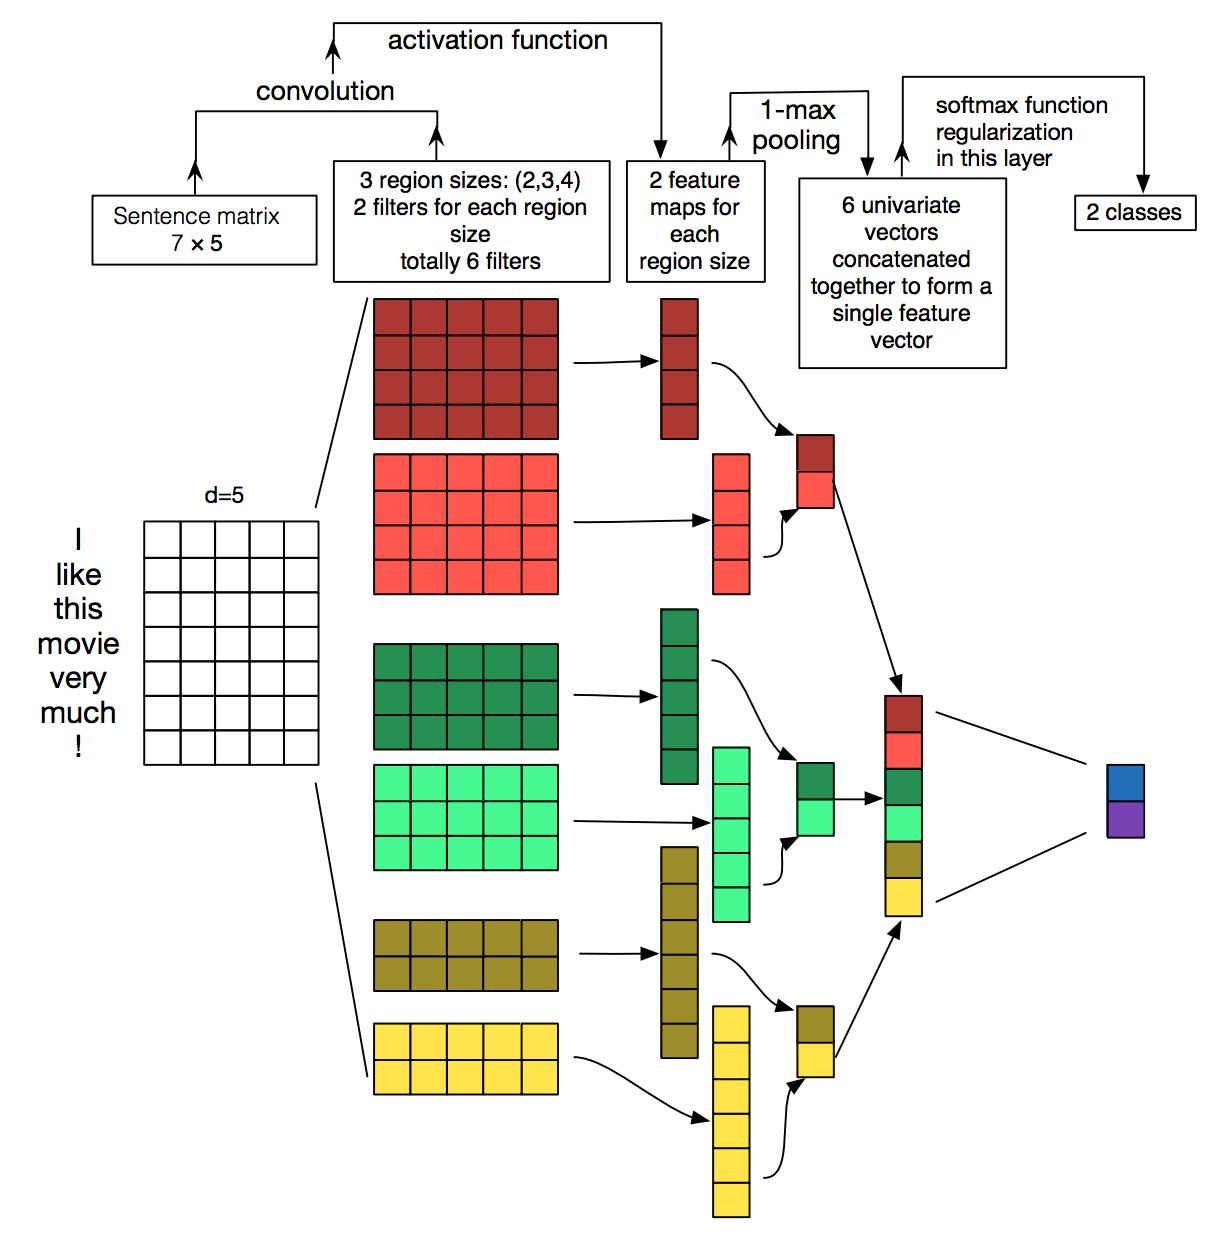!

Build model TextCNN

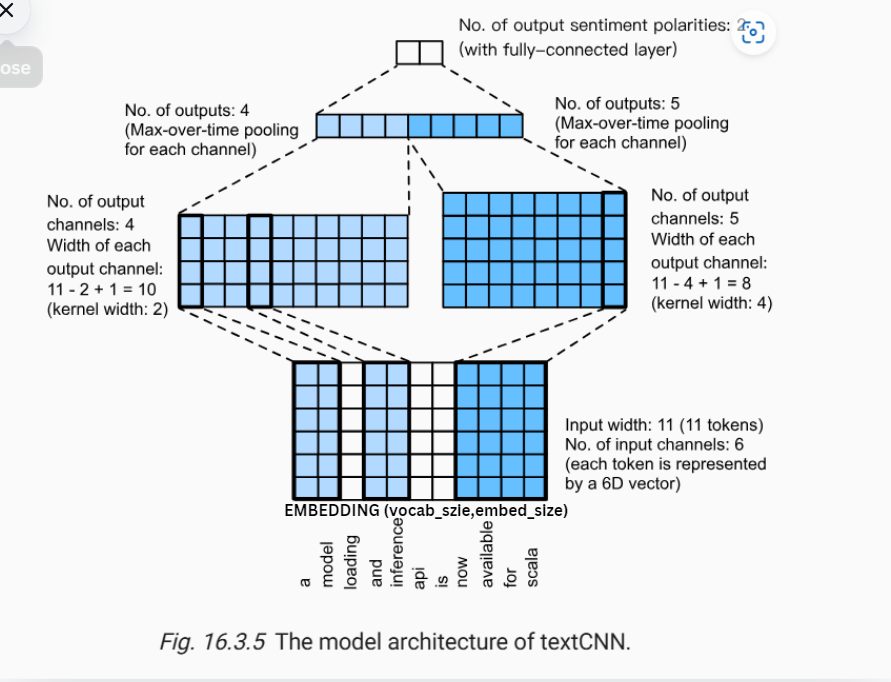

In [1]:
!pip install d2l

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.9/58.9 kB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 111.7/111.7 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 76.1 MB/s eta 0:00:00:00:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 75.4 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 86.4 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.6/62.6 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.4/34.4 MB 46.3 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.3/98.3 kB 6.0 MB/s eta 0:00:00
  Attempting uninstall: requests
    Found existing installation: requests 2.32.3
    Uninstalling requests-2.32.3:
      Successfully uninstalled requests-2.32.3
  Attempting uninstall: pyparsing
    Found existing installation: pyparsing 3.1.2
    Uninstalling pyparsing-3.1.2:
      Successfully uninstalled pyparsing-3.1.

In [6]:
from torch import nn
import torch
from d2l import torch as d2l

In [7]:
class TextCNN(nn.Module):
    def __init__(self, vocab_size, embed_size, kernel_sizes, num_channels,
                 **kwargs):
        super(TextCNN, self).__init__(**kwargs)
        self.embedding = nn.Embedding(vocab_size, embed_size)
        # The embedding layer not to be trained
        self.constant_embedding = nn.Embedding(vocab_size, embed_size)
        self.dropout = nn.Dropout(0.5)
        self.decoder = nn.Linear(sum(num_channels), 2)
        # The max-over-time pooling layer has no parameters, so this instance
        # can be shared
        self.pool = nn.AdaptiveAvgPool1d(1)
        self.relu = nn.ReLU()
        # Create multiple one-dimensional convolutional layers
        self.convs = nn.ModuleList()
        for c, k in zip(num_channels, kernel_sizes):
            self.convs.append(nn.Conv1d(2 * embed_size, c, k))

    def forward(self, inputs):
        # Concatenate two embedding layer outputs with shape (batch size, no.
        # of tokens, token vector dimension) along vectors
        embeddings = torch.cat((
            self.embedding(inputs), self.constant_embedding(inputs)), dim=2)
        # Per the input format of one-dimensional convolutional layers,
        # rearrange the tensor so that the second dimension stores channels
        embeddings = embeddings.permute(0, 2, 1)
        # For each one-dimensional convolutional layer, after max-over-time
        # pooling, a tensor of shape (batch size, no. of channels, 1) is
        # obtained. Remove the last dimension and concatenate along channels
        encoding = torch.cat([
            torch.squeeze(self.relu(self.pool(conv(embeddings))), dim=-1)
            for conv in self.convs], dim=1)
        outputs = self.decoder(self.dropout(encoding))
        return outputs

In [9]:
embed_size, kernel_sizes, num_channels = 100, [3, 4, 5], [100, 100, 100]
devices = d2l.try_all_gpus()
net = TextCNN(len(vocab), embed_size, kernel_sizes, num_channels)
def init_weights(module):
    if type(module) in (nn.Linear, nn.Conv1d):
        nn.init.xavier_uniform_(module.weight)
net.apply(init_weights)

NameError: name 'vocab' is not defined

In [ ]:
glove_Embedding = d2l.TokenEmbedding('glove.6b.100d')
embeds = glove_Embedding[vocab.idx_to_token]
net.embedding.weight.data.copy_(embeds)
net.constant_embedding.weight.data.copy_(embeds)
net.constant_embedding.weight.requires_grad = False

In [ ]:
lr, num_epochs = 0.001, 5
trainer = torch.optim.Adam(net.parameters(), lr=lr)
loss = nn.CrossEntropyLoss(reduction="none")
d2l.train_ch13(net, train_iter, test_iter, loss, trainer, num_epochs, devices)

In [ ]:
d2l.predict_sentiment(net, vocab, 'this movie is so great')

In [ ]:
d2l.predict_sentiment(net, vocab, 'this movie is so bad')

In [1]:
!pip install d2l

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.9/58.9 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 111.7/111.7 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 76.9 MB/s eta 0:00:00:00:01:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 76.8 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 77.9 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.6/62.6 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.4/34.4 MB 45.2 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.3/98.3 kB 4.9 MB/s eta 0:00:00
  Attempting uninstall: requests
    Found existing installation: requests 2.32.3
    Uninstalling requests-2.32.3:
      Successfully uninstalled requests-2.32.3
  Attempting uninstall: pyparsing
    Found existing installation: pyparsing 3.1.2
    Uninstalling pyparsing-3.1.2:
      Successfully uninstalled pyparsing-3.1.2

##  Natural Language Inference and the Dataset

Suy diễn ngôn ngữ tự nhiên (Natural Language Inference - NLI) nghiên cứu xem liệu một giả thuyết có thể được suy ra từ một tiền đề, trong đó cả hai đều là các chuỗi văn bản. Nói cách khác, suy diễn ngôn ngữ tự nhiên xác định mối quan hệ logic giữa một cặp chuỗi văn bản. Những mối quan hệ này thường thuộc ba loại:

**Hàm chứa (Entailment):** Giả thuyết có thể được suy ra từ tiền đề.

**Mâu thuẫn (Contradiction):** Phủ định của giả thuyết có thể được suy ra từ tiền đề.

**Trung lập (Neutral):** Tất cả các trường hợp khác.

Suy diễn ngôn ngữ tự nhiên còn được biết đến với tên gọi là bài toán nhận diện hàm chứa văn bản (Recognizing Textual Entailment - RTE). Ví dụ, cặp sau sẽ được gán nhãn là hàm chứa vì "thể hiện tình cảm" trong giả thuyết có thể được suy ra từ "ôm nhau" trong tiền đề.

**Tiền đề:** Hai người phụ nữ đang ôm nhau.

**Giả thuyết:** Hai người phụ nữ đang thể hiện tình cảm.

Ví dụ sau là mâu thuẫn vì "chạy thử ví dụ lập trình" chỉ ra "không ngủ" thay vì "đang ngủ".

**Tiền đề:** Một người đàn ông đang chạy thử ví dụ lập trình từ Dive into Deep Learning.

**Giả thuyết:** Người đàn ông đang ngủ.

Ví dụ thứ ba thể hiện mối quan hệ trung lập vì không thể suy ra từ việc "đang biểu diễn cho chúng tôi" rằng "nổi tiếng" hay "không nổi tiếng".

**Tiền đề:** Các nhạc sĩ đang biểu diễn cho chúng tôi.

**Giả thuyết:** Các nhạc sĩ nổi tiếng.

Suy diễn ngôn ngữ tự nhiên đã trở thành một chủ đề trung tâm trong việc hiểu ngôn ngữ tự nhiên. Nó có nhiều ứng dụng rộng rãi từ truy xuất thông tin đến trả lời câu hỏi trong các miền mở. Để nghiên cứu vấn đề này, chúng ta sẽ bắt đầu bằng việc điều tra một tập dữ liệu chuẩn về suy diễn ngôn ngữ tự nhiên.

Ví dụ về tập dữ liệu được sử dụng để thực hiện downstream application : natural language inference 

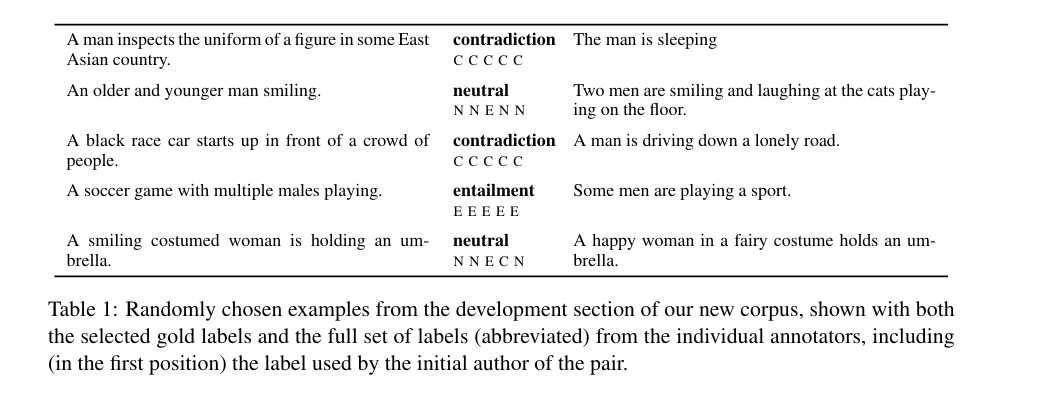

**Tổng quan về SNLI:**

Số lượng cặp câu: Hơn 500.000 cặp câu văn bản.

Ngôn ngữ: Tiếng Anh.

Cấu trúc của mỗi cặp: Mỗi cặp bao gồm hai câu văn bản — một tiền đề (premise) và một giả thuyết (hypothesis).

Nhãn: Mỗi cặp câu được gán một trong ba nhãn phân loại:

Hàm chứa (Entailment): Giả thuyết có thể được suy ra từ tiền đề.

Mâu thuẫn (Contradiction): Giả thuyết mâu thuẫn với tiền đề.

Trung lập (Neutral): Giả thuyết không thể suy ra từ tiền đề và cũng không mâu thuẫn.

Dưới đây là một vài ví dụ từ tập dữ liệu **Stanford Natural Language Inference (SNLI)**, bao gồm tiền đề, giả thuyết và nhãn tương ứng:

 Ví dụ 1:
- **Tiền đề (premise):** A soccer game with multiple males playing.
  *(Một trận bóng đá với nhiều người đàn ông đang chơi.)*
- **Giả thuyết (hypothese):** Some men are playing a sport.
  *(Một số người đàn ông đang chơi thể thao.)*
- **Nhãn (label):** 
    **Hàm chứa (Entailment)**
  - *Giả thuyết được suy ra từ tiền đề vì "chơi bóng đá" là một dạng "chơi thể thao".*

---

 Ví dụ 2:
- **Tiền đề:** A man inspects the uniform of a figure in some East Asian country.
  *(Một người đàn ông đang kiểm tra đồng phục của một nhân vật ở một nước Đông Á.)*
- **Giả thuyết:** The man is sleeping.
  *(Người đàn ông đang ngủ.)*
- **Nhãn:** **Mâu thuẫn (Contradiction)**
  - *Giả thuyết mâu thuẫn với tiền đề, vì "kiểm tra đồng phục" cho thấy người đàn ông đang hoạt động, không thể đang ngủ.*

---

 Ví dụ 3:
- **Tiền đề:** A large, gray elephant walks beside a herd of zebras.
  *(Một con voi lớn màu xám đang đi cạnh một đàn ngựa vằn.)*
- **Giả thuyết:** The elephant is walking alongside other elephants.
  *(Con voi đang đi bên cạnh những con voi khác.)*
- **Nhãn:** **Mâu thuẫn (Contradiction)**
  - *Giả thuyết mâu thuẫn với tiền đề, vì tiền đề đề cập đến đàn ngựa vằn, không phải những con voi khác.*

---

 Ví dụ 4:
- **Tiền đề:** A young child is sitting in front of a piece of cake and is ready to eat.
  *(Một đứa trẻ đang ngồi trước một miếng bánh và sẵn sàng ăn.)*
- **Giả thuyết:** The child is about to enjoy a dessert.
  *(Đứa trẻ sắp thưởng thức món tráng miệng.)*
- **Nhãn:** **Hàm chứa (Entailment)**
  - *Giả thuyết được suy ra từ tiền đề, vì "một miếng bánh" có thể coi là món tráng miệng và hành động "sẵn sàng ăn" tương ứng với việc chuẩn bị thưởng thức.*

---

Ví dụ 5:
- **Tiền đề:** Two women are embracing while holding to-go containers.
  *(Hai người phụ nữ đang ôm nhau trong khi cầm các hộp đựng đồ mang về.)*
- **Giả thuyết:** The women are hugging.
  *(Những người phụ nữ đang ôm nhau.)*
- **Nhãn:** **Hàm chứa (Entailment)**
  - *Giả thuyết được suy ra từ tiền đề vì hành động "ôm nhau" và "embracing" là tương đương.*

---

 Ví dụ 6:
- **Tiền đề:** A person on a horse jumps over a broken down airplane.
  *(Một người đang cưỡi ngựa nhảy qua một chiếc máy bay bị hỏng.)*
- **Giả thuyết:** A person is training his horse for a competition.
  *(Một người đang huấn luyện ngựa của mình cho một cuộc thi.)*
- **Nhãn:** **Trung lập (Neutral)**
  - *Không thể suy ra từ tiền đề rằng người đó đang huấn luyện ngựa cho một cuộc thi hay không, nhưng điều này cũng không mâu thuẫn với thông tin trong tiền đề.*

---

Những ví dụ trên thể hiện rõ các mối quan hệ khác nhau trong suy diễn ngôn ngữ tự nhiên: hàm chứa, mâu thuẫn, và trung lập. SNLI là một tập dữ liệu có tính đa dạng cao và được sử dụng rộng rãi trong việc phát triển các mô hình học máy, đặc biệt là trong các nhiệm vụ phân loại văn bản và hiểu ngữ nghĩa.

In [5]:
import os 
import re
import torch 
from torch import nn
from d2l import torch as d2l

In [3]:
d2l.DATA_HUB['SNLI'] = ('https://nlp.stanford.edu/projects/snli/snli_1.0.zip','19604-5a2b841-51e759e46cbc0')

data_dir = d2l.download_extract('SNLI')

In [12]:
import re

text = "  Đây là    một ví dụ     về việc sử dụng biểu thức chính quy."
# Thay thế các khoảng trắng liên tiếp bằng một khoảng trắng duy nhất
result = re.sub(r'\s{2,}', ' ', text)

print(result)


 Đây là một ví dụ về việc sử dụng biểu thức chính quy.


In [13]:
print(result.strip())

Đây là một ví dụ về việc sử dụng biểu thức chính quy.


In [42]:
def read_snli(data_dir, is_train):
    """Read the SNLI dataset into premises, hypotheses, and labels."""
    def extract_text(s):
        # Remove information that will not be used by us
        s = re.sub('\\(', '', s)
        s = re.sub('\\)', '', s)
        # Substitute two or more consecutive whitespace with space
        s = re.sub('\\s{2,}', ' ', s)
        return s.strip()
    label_set = {'entailment': 0, 'contradiction': 1, 'neutral': 2}
    file_name = os.path.join(data_dir, 'snli_1.0_train.txt'
                             if is_train else 'snli_1.0_test.txt')
    with open(file_name, 'r') as f:
        rows = [row.split('\t') for row in f.readlines()[1:]]
    premises = [extract_text(row[1]) for row in rows if row[0] in label_set]
    hypotheses = [extract_text(row[2]) for row in rows if row[0] in label_set]
    labels = [label_set[row[0]] for row in rows if row[0] in label_set]
    
    return premises, hypotheses, labels

In [43]:
train_data = read_snli(data_dir, is_train=True)
for x0, x1, y in zip(train_data[0][:3], train_data[1][:3], train_data[2][:3]):
    print('premise:', x0)
    print('hypothesis:', x1)
    print('label:', y)

premise: A person on a horse jumps over a broken down airplane .
hypothesis: A person is training his horse for a competition .
label: 2
premise: A person on a horse jumps over a broken down airplane .
hypothesis: A person is at a diner , ordering an omelette .
label: 1
premise: A person on a horse jumps over a broken down airplane .
hypothesis: A person is outdoors , on a horse .
label: 0


In [50]:
class SNLIDataset(torch.utils.data.Dataset):
    """A customized dataset to load the SNLI dataset."""
    def __init__(self, dataset, num_steps, vocab=None):
        self.num_steps = num_steps
        all_premise_tokens = d2l.tokenize(dataset[0])
        all_hypothesis_tokens = d2l.tokenize(dataset[1])
        if vocab is None:
            self.vocab = d2l.Vocab(all_premise_tokens + all_hypothesis_tokens,
                                   min_freq=5, reserved_tokens=['<pad>'])
        else:
            self.vocab = vocab
        self.premises = self._pad(all_premise_tokens)
        self.hypotheses = self._pad(all_hypothesis_tokens)
        self.labels = torch.tensor(dataset[2])
        print('read ' + str(len(self.premises)) + ' examples')

    def _pad(self, lines):
        return torch.tensor([d2l.truncate_pad(
            self.vocab[line], self.num_steps, self.vocab['<pad>'])
                         for line in lines])

    def __getitem__(self, idx):
        return (self.premises[idx], self.hypotheses[idx]), self.labels[idx]

    def __len__(self):
        return len(self.premises)

In [51]:
def load_data_snli(batch_size, num_steps=50):
    """Download the SNLI dataset and return data iterators and vocabulary."""
    num_workers = d2l.get_dataloader_workers()
    data_dir = d2l.download_extract('SNLI')
    train_data = read_snli(data_dir, True)
    test_data = read_snli(data_dir, False)
    train_set = SNLIDataset(train_data, num_steps)
    test_set = SNLIDataset(test_data, num_steps, train_set.vocab)
    train_iter = torch.utils.data.DataLoader(train_set, batch_size,
                                             shuffle=True,
                                             num_workers=num_workers)
    test_iter = torch.utils.data.DataLoader(test_set, batch_size,
                                            shuffle=False,
                                            num_workers=num_workers)
    return train_iter, test_iter, train_set.vocab

In [52]:
train_iter, test_iter, vocab = load_data_snli(128, 50)
len(vocab)

read 549367 examples
read 9824 examples


18678

Machine translation has long been evaluated based on superficial 𝑛 -gram matching between an output translation and a ground-truth translation. Can you design a measure for evaluating machine translation results by using natural language inference? 

##  Natural Language Inference: Using Attention

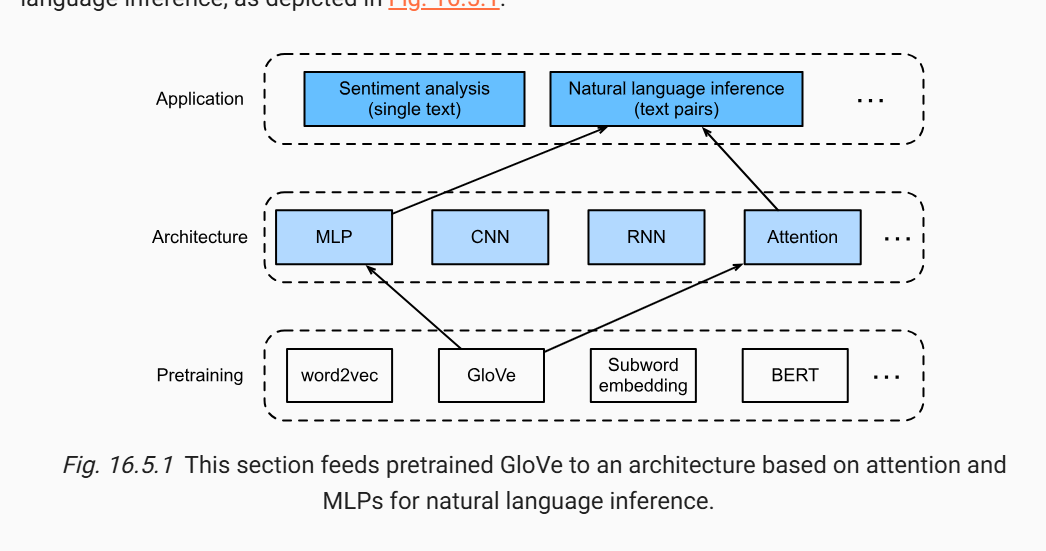

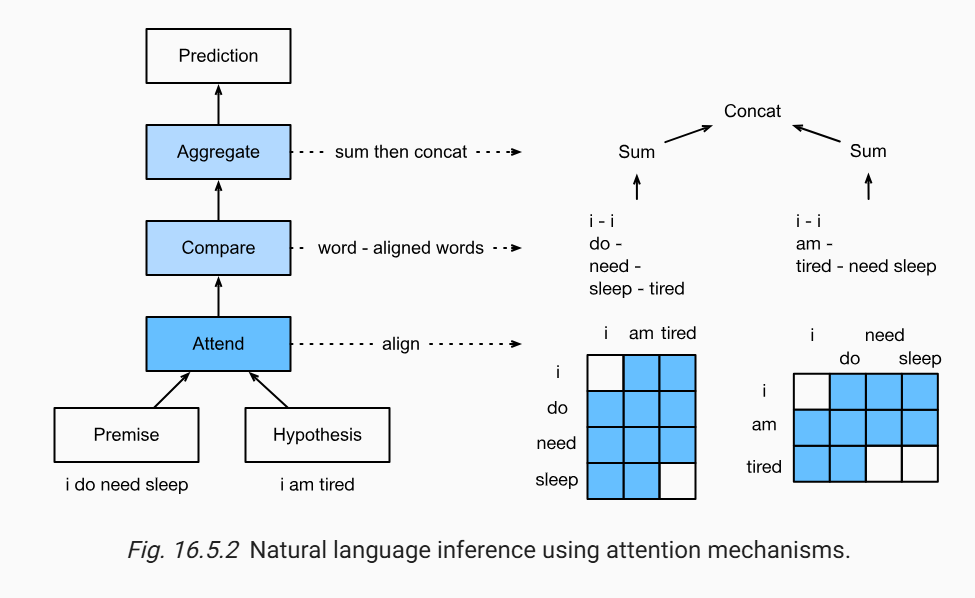

In [2]:
!pip install d2l

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.9/58.9 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 111.7/111.7 kB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 84.2 MB/s eta 0:00:00:00:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 83.9 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 91.0 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.6/62.6 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.4/34.4 MB 47.2 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.3/98.3 kB 6.6 MB/s eta 0:00:00
  Attempting uninstall: requests
    Found existing installation: requests 2.32.3
    Uninstalling requests-2.32.3:
      Successfully uninstalled requests-2.32.3
  Attempting uninstall: pyparsing
    Found existing installation: pyparsing 3.1.2
    Uninstalling pyparsing-3.1.2:
      Successfully uninstalled pyparsing-3.1.

In [3]:
import torch
from torch import nn
from d2l import torch as d2l
from torch.nn import functional as F


Attention

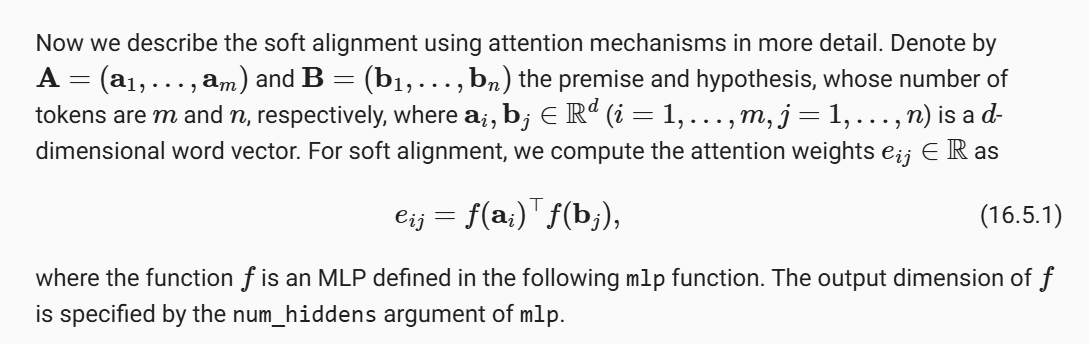

Bước đầu tiên là liên kết các token trong một chuỗi văn bản với mỗi token trong chuỗi còn lại. Giả sử rằng tiền đề (premise) là "i do need sleep" và giả thuyết (hypothesis) là "i am tired". Do sự tương đồng về ngữ nghĩa, chúng ta có thể muốn liên kết "i" trong giả thuyết với "i" trong tiền đề và liên kết "tired" trong giả thuyết với "sleep" trong tiền đề. Tương tự, chúng ta có thể muốn liên kết "i" trong tiền đề với "i" trong giả thuyết, và liên kết "need" và "sleep" trong tiền đề với "tired" trong giả thuyết. Lưu ý rằng sự liên kết này là mềm (soft) bằng cách sử dụng trung bình có trọng số, trong đó lý tưởng là các trọng số lớn được gán cho các token cần được liên kết. Để dễ minh họa, Hình 16.5.2 thể hiện sự liên kết này một cách cứng (hard).

MLP layer

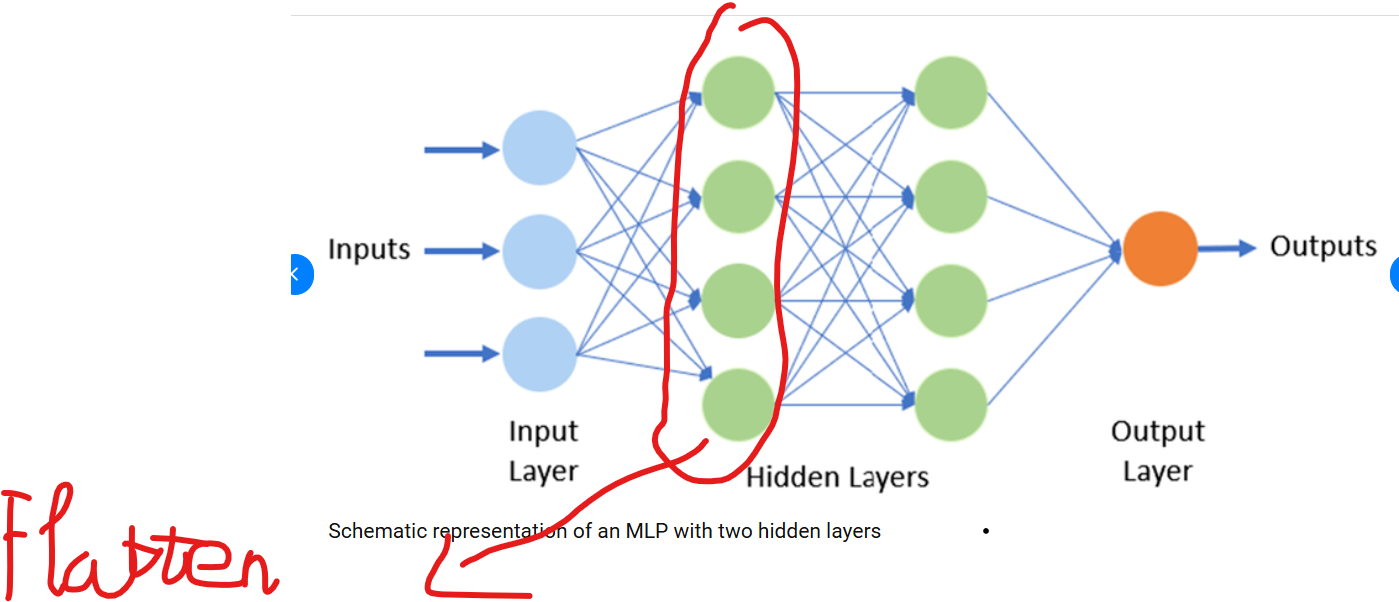

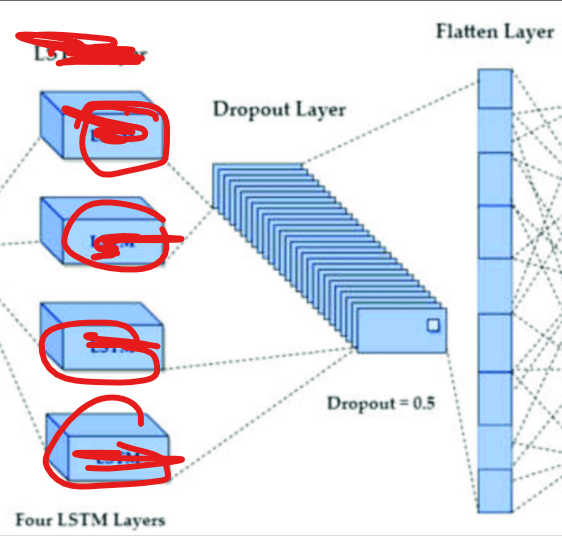

In [18]:
def mlp(num_inputs, num_hiddens, flatten):
    net = []
    net.append(nn.Dropout(0.2))
    net.append(nn.Linear(num_inputs, num_hiddens))
    net.append(nn.ReLU())
    if flatten:
        net.append(nn.Flatten(start_dim=1))
    net.append(nn.Dropout(0.2))
    net.append(nn.Linear(num_hiddens, num_hiddens))
    net.append(nn.ReLU())
    if flatten:
        net.append(nn.Flatten(start_dim=1))
    return nn.Sequential(*net)

In [17]:
class Attend(nn.Module):
    def __init__(self, num_inputs, num_hiddens, **kwargs):
        super(Attend, self).__init__(**kwargs)
        self.f = mlp(num_inputs, num_hiddens, flatten=False)

    def forward(self, A, B):
        # Shape of `A`/`B`: (`batch_size`, no. of tokens in sequence A/B,
        # `embed_size`)
        # Shape of `f_A`/`f_B`: (`batch_size`, no. of tokens in sequence A/B,
        # `num_hiddens`)
        f_A = self.f(A)
        f_B = self.f(B)
        # Shape of `e`: (`batch_size`, no. of tokens in sequence A,
        # no. of tokens in sequence B)
        e = torch.bmm(f_A, f_B.permute(0, 2, 1))
        # Shape of `beta`: (`batch_size`, no. of tokens in sequence A,
        # `embed_size`), where sequence B is softly aligned with each token
        # (axis 1 of `beta`) in sequence A
        beta = torch.bmm(F.softmax(e, dim=-1), B)
        # Shape of `alpha`: (`batch_size`, no. of tokens in sequence B,
        # `embed_size`), where sequence A is softly aligned with each token
        # (axis 1 of `alpha`) in sequence B
        alpha = torch.bmm(F.softmax(e.permute(0, 2, 1), dim=-1), A)
        return beta, alpha

Comparing

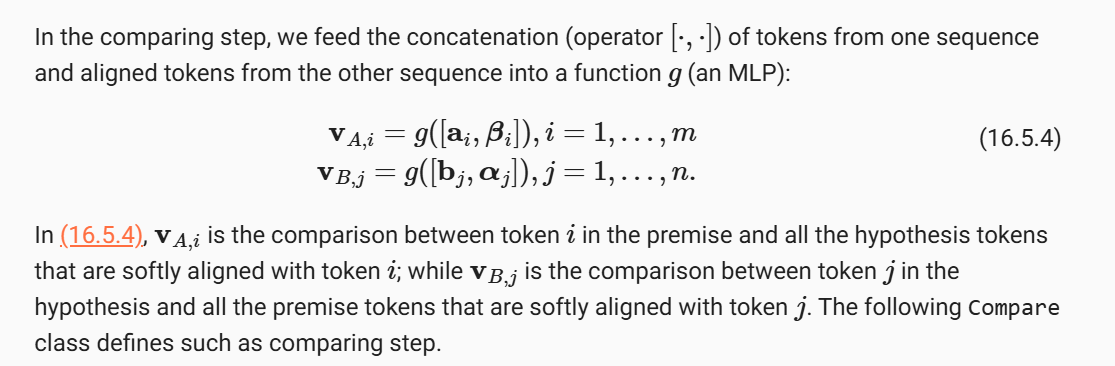

In [16]:
class Compare(nn.Module):
    def __init__(self, num_inputs, num_hiddens, **kwargs):
        super(Compare, self).__init__(**kwargs)
        self.g = mlp(num_inputs, num_hiddens, flatten=False)

    def forward(self, A, B, beta, alpha):
        V_A = self.g(torch.cat([A, beta], dim=2))
        V_B = self.g(torch.cat([B, alpha], dim=2))
        return V_A, V_B

Aggregating

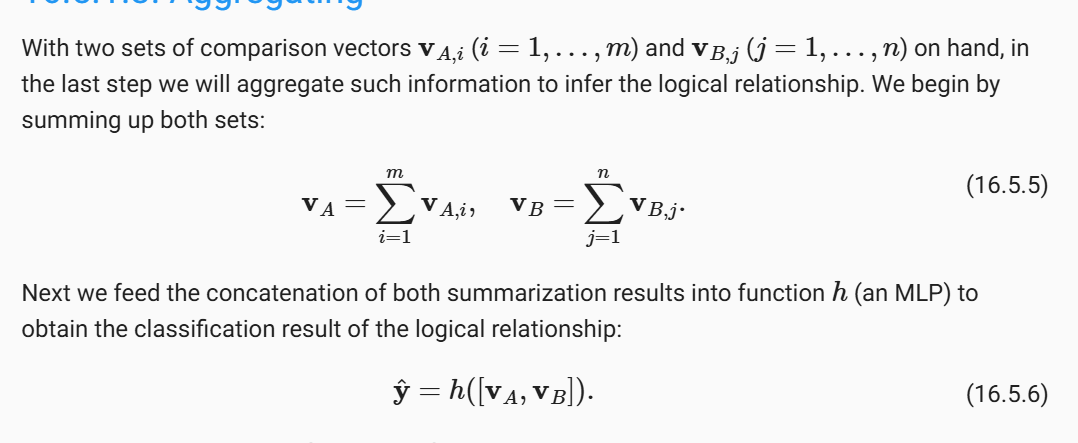

In [15]:
class Aggregate(nn.Module):
    def __init__(self, num_inputs, num_hiddens, num_outputs, **kwargs):
        super(Aggregate, self).__init__(**kwargs)
        self.h = mlp(num_inputs, num_hiddens, flatten=True)
        self.linear = nn.Linear(num_hiddens, num_outputs)

    def forward(self, V_A, V_B):
        # Sum up both sets of comparison vectors
        V_A = V_A.sum(dim=1)
        V_B = V_B.sum(dim=1)
        # Feed the concatenation of both summarization results into an MLP
        Y_hat = self.linear(self.h(torch.cat([V_A, V_B], dim=1)))
        return Y_hat

In [14]:
class DecomposableAttention(nn.Module):
    def __init__(self, vocab, embed_size, num_hiddens, num_inputs_attend=100,
                 num_inputs_compare=200, num_inputs_agg=400, **kwargs):
        super(DecomposableAttention, self).__init__(**kwargs)
        self.embedding = nn.Embedding(len(vocab), embed_size)
        self.attend = Attend(num_inputs_attend, num_hiddens)
        self.compare = Compare(num_inputs_compare, num_hiddens)
        # There are 3 possible outputs: entailment, contradiction, and neutral
        self.aggregate = Aggregate(num_inputs_agg, num_hiddens, num_outputs=3)

    def forward(self, X):
        premises, hypotheses = X
        A = self.embedding(premises)
        B = self.embedding(hypotheses)
        beta, alpha = self.attend(A, B)
        V_A, V_B = self.compare(A, B, beta, alpha)
        Y_hat = self.aggregate(V_A, V_B)
        return Y_hat

In [12]:
batch_size, num_steps = 256, 50
train_iter, test_iter, vocab = d2l.load_data_snli(batch_size, num_steps)

read 549367 examples
read 9824 examples


In [19]:
embed_size, num_hiddens, devices = 100, 200, d2l.try_all_gpus()
net = DecomposableAttention(vocab, embed_size, num_hiddens)
glove_embedding = d2l.TokenEmbedding('glove.6b.100d')
embeds = glove_embedding[vocab.idx_to_token]
net.embedding.weight.data.copy_(embeds);

In [20]:
def split_batch_multi_inputs(X, y, devices):
    """Split multi-input `X` and `y` into multiple devices."""
    X = list(zip(*[gluon.utils.split_and_load(
        feature, devices, even_split=False) for feature in X]))
    return (X, gluon.utils.split_and_load(y, devices, even_split=False))

loss 0.496, train acc 0.805, test acc 0.819
17765.7 examples/sec on [device(type='cuda', index=0), device(type='cuda', index=1)]


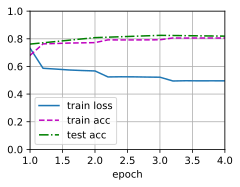

In [21]:
lr, num_epochs = 0.001, 4
trainer = torch.optim.Adam(net.parameters(), lr=lr)
loss = nn.CrossEntropyLoss(reduction="none")
d2l.train_ch13(net, train_iter, test_iter, loss, trainer, num_epochs, devices)

In [22]:
def predict_snli(net, vocab, premise, hypothesis):
    """Predict the logical relationship between the premise and hypothesis."""
    net.eval()
    premise = torch.tensor(vocab[premise], device=d2l.try_gpu())
    hypothesis = torch.tensor(vocab[hypothesis], device=d2l.try_gpu())
    label = torch.argmax(net([premise.reshape((1, -1)),
                           hypothesis.reshape((1, -1))]), dim=1)
    return 'entailment' if label == 0 else 'contradiction' if label == 1 \
            else 'neutral'

In [23]:
predict_snli(net, vocab, ['he', 'is', 'good', '.'], ['he', 'is', 'bad', '.'])

'contradiction'

What are major drawbacks of the decomposable attention model for natural language inference?



d dimensional embedding

l sequences length 

Tuy nhiêu khi l > d thì nó không còn đơn giản và cho hiệu suất tính toán cao nữa. Hiệu suất tính toán của nó còn cao hơn các phương pháp bình thường. Vì vậy nhược điểm chính là khi nó gặp các câu quá dài thì nó không còn là một phương pháp hiệu quả nữa.

xem thêm bài báo gốc : https://arxiv.org/pdf/1606.01933

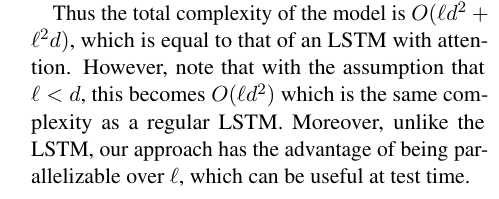

Bài tập :
Suppose that we want to get the level of semantical similarity (e.g., a continuous value between 0 and 1) for any pair of sentences. How shall we collect and label the dataset? Can you design a model with attention mechanisms?



Giả sử chúng ta muốn đạt được mức độ tương tự về mặt ngữ nghĩa (ví dụ: giá trị liên tục trong khoảng từ 0 đến 1) cho bất kỳ cặp câu nào. Chúng ta sẽ thu thập và dán nhãn tập dữ liệu như thế nào? Bạn có thể thiết kế một mô hình với cơ chế chú ý không?


https://readmedium.com/semantic-textual-similarity-with-bert-fc800656e7a3

In [6]:
from datasets import load_dataset
dataset = load_dataset("stsb_multi_mt", name="en", split="train")
print(dataset[0])
print(dataset[1])

README.md:   0%|          | 0.00/11.4k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/470k [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/108k [00:00<?, ?B/s]

dev-00000-of-00001.parquet:   0%|          | 0.00/142k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/5749 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1379 [00:00<?, ? examples/s]

Generating dev split:   0%|          | 0/1500 [00:00<?, ? examples/s]

{'sentence1': 'A plane is taking off.', 'sentence2': 'An air plane is taking off.', 'similarity_score': 5.0}
{'sentence1': 'A man is playing a large flute.', 'sentence2': 'A man is playing a flute.', 'similarity_score': 3.799999952316284}


**STSB (Semantic Textual Similarity Benchmark)** là một bộ dữ liệu được sử dụng rộng rãi trong các nhiệm vụ đánh giá mức độ tương đồng về ngữ nghĩa giữa các cặp câu trong ngôn ngữ tự nhiên. Nó là một phần quan trọng trong các bài kiểm tra để đánh giá các mô hình xử lý ngôn ngữ tự nhiên (NLP), đặc biệt là trong các bài kiểm tra về **semantic textual similarity (STS)** - tương đồng ngữ nghĩa văn bản. Dưới đây là tổng quan về bộ dữ liệu này:

 1. **Mục tiêu**
Bộ dữ liệu STSB được thiết kế để đánh giá mức độ tương đồng ngữ nghĩa giữa các cặp câu, với mục đích chính là kiểm tra xem hai câu có mang ý nghĩa tương tự nhau hay không. Các mô hình NLP sẽ dự đoán điểm tương đồng trên thang điểm từ 0 đến 5, với:
- **0**: Hai câu hoàn toàn không liên quan.
- **5**: Hai câu có ý nghĩa giống hệt nhau.

 2. **Nguồn dữ liệu**
STSB được tổng hợp từ nhiều nguồn khác nhau, bao gồm:
- **Tin tức**: Các câu trích từ các bài báo, báo cáo.
- **Trang web khoa học**: Các văn bản về các nghiên cứu và bài viết khoa học.
- **Diễn đàn**: Các đoạn hội thoại từ các diễn đàn trực tuyến.
- **Phụ đề phim**: Các câu thoại từ các tập phim và chương trình truyền hình.
Điều này tạo ra một tập dữ liệu đa dạng và thực tế, phản ánh nhiều phong cách viết và ngữ cảnh khác nhau.

 3. **Phân loại dữ liệu**
Bộ dữ liệu STSB được chia thành ba tập chính:
- **Train**: Dùng để huấn luyện mô hình.
- **Dev (Development)**: Dùng để điều chỉnh và tối ưu hóa mô hình.
- **Test**: Dùng để đánh giá hiệu suất cuối cùng của mô hình.

 4. **Nhiệm vụ**
Nhiệm vụ của mô hình là dự đoán điểm tương đồng cho mỗi cặp câu dựa trên các biểu diễn ngữ nghĩa của chúng. Những điểm số này thường là số thực trong khoảng từ 0 đến 5, và hiệu suất của mô hình được đo lường bằng các chỉ số như **Pearson correlation coefficient** hoặc **Spearman's rank correlation coefficient** giữa dự đoán của mô hình và các nhãn thực tế.

 5. **Các ứng dụng**
STSB thường được sử dụng trong nhiều ứng dụng của NLP như:
- **Đo lường sự tương đồng ngữ nghĩa** giữa các văn bản.
- **Đoán văn bản song ngữ** trong các nhiệm vụ dịch máy.
- **Các hệ thống hỏi đáp** (question-answering), nơi cần đánh giá xem câu hỏi và câu trả lời có liên quan không.
- **Tóm tắt văn bản**: So sánh các đoạn tóm tắt với văn bản gốc.

 6. **Ý nghĩa**
STSB là một tiêu chuẩn quan trọng để đánh giá khả năng của các mô hình NLP trong việc nắm bắt ngữ nghĩa, và nó thường được sử dụng để kiểm tra các mô hình ngôn ngữ hiện đại như BERT, RoBERTa, và các mô hình transformer khác.

 7. **Công bố**
STSB được công bố lần đầu vào năm 2017 như một phần của cuộc thi **SemEval-2017 Task 1**. Kể từ đó, nó đã trở thành một trong những bộ dữ liệu phổ biến để kiểm tra các mô hình dự đoán sự tương đồng ngữ nghĩa.

Bộ dữ liệu này giúp cung cấp một tiêu chuẩn để đánh giá mức độ hiểu ngữ nghĩa giữa các văn bản, giúp cải thiện nhiều hệ thống ứng dụng trong xử lý ngôn ngữ tự nhiên.

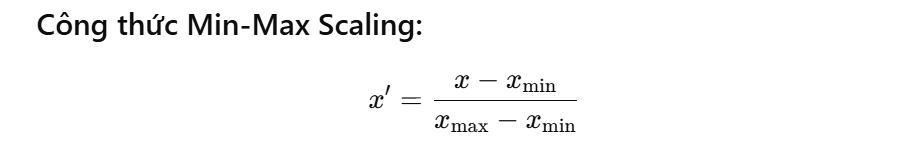

In [7]:
import pandas as pd

dataset = pd.DataFrame(dataset)

In [8]:
#  Min-Max Scaling 
from sklearn.preprocessing import MinMaxScaler
import numpy as np 
scaler = MinMaxScaler()

X = np.array(dataset['similarity_score']).reshape(-1,1)
Y = scaler.fit_transform(X)
Y = Y.flatten()
Y = list(Y)
dataset['similarity_score'] = Y

In [ ]:
for i in dataset

In [4]:
dataset.head()

sentence1  \
0                         A plane is taking off.   
1                A man is playing a large flute.   
2  A man is spreading shreded cheese on a pizza.   
3                   Three men are playing chess.   
4                    A man is playing the cello.   

                                           sentence2  similarity_score  
0                        An air plane is taking off.              1.00  
1                          A man is playing a flute.              0.76  
2  A man is spreading shredded cheese on an uncoo...              0.76  
3                         Two men are playing chess.              0.52  
4                 A man seated is playing the cello.              0.85

Semantic Contextual Similarity 

For SBERT

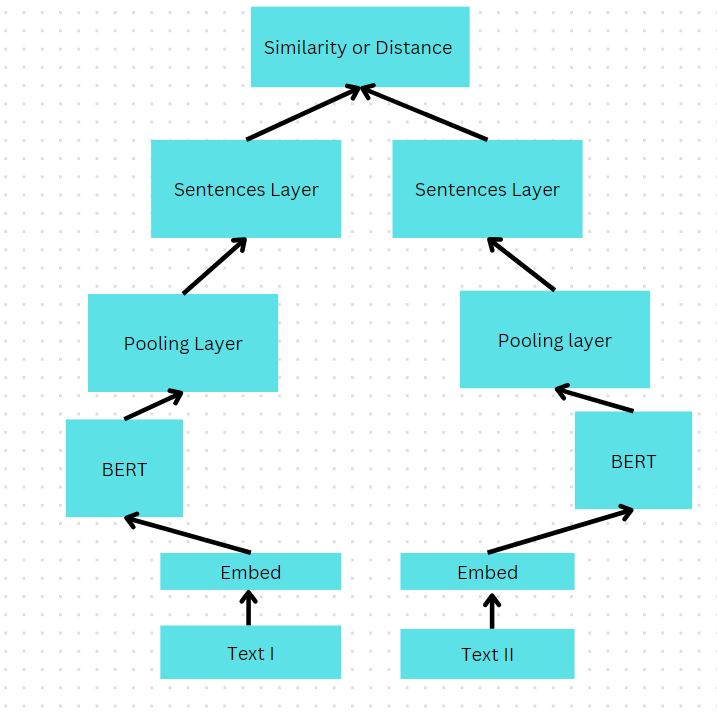

SBERT – Mô hình dựa trên máy biến áp trong đó phần mã hóa nắm bắt nghĩa của các từ trong câu.

In [ ]:
!pip install sentence-transformers


Now we are going to implement SBERT model based on BERT, but you can also implement SBERT with BERT variants like distilBERT or RoBERTa, or even load a model that has been pretrained on particular dataset. You can find all of the available models here.



Xem theem SBERT : https://arxiv.org/pdf/1908.10084 for application Semantic Textual Similarity 

In [17]:
from sentence_transformers import SentenceTransformer, models

word_embedding_model = models.Transformer('bert-base-uncased', max_seq_length=128)
pooling_model = models.Pooling(word_embedding_model.get_word_embedding_dimension())
sts_bert_model = SentenceTransformer(modules=[word_embedding_model, pooling_model])

/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [3]:
!pip install transformers

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


In [10]:
from transformers import BertTokenizer

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
sentence_1 = [i for i in dataset['sentence1']]
sentence_2 = [i for i in dataset['sentence2']]

In [14]:
text_cat = [[str(x), str(y)] for x, y in zip(sentence_1, sentence_2)][0]

input_data = tokenizer(text_cat, padding='max_length', max_length = 128, truncation=True, return_tensors="pt")
# truncation = True ensure exceed length sentence < max_length
# return_tensor : output tensor with pytorch
# padding sentence == max_length 

In [18]:
output = sts_bert_model(input_data)


RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cuda:0 and cpu! (when checking argument for argument index in method wrapper_CUDA__index_select)

Model SBERT 

In [32]:
class STSBertModel(torch.nn.Module):

    def __init__(self):

        super(STSBertModel, self).__init__()

        word_embedding_model = models.Transformer('bert-base-uncased', max_seq_length=128)
        pooling_model = models.Pooling(word_embedding_model.get_word_embedding_dimension())
        self.sts_model = SentenceTransformer(modules=[word_embedding_model, pooling_model])

    def forward(self, input_data):

        output = self.sts_model(input_data)

        return output

DataSET STSB (Semantic Textual Similarity Benchmark)

In [20]:
dataset.head()

sentence1  \
0                         A plane is taking off.   
1                A man is playing a large flute.   
2  A man is spreading shreded cheese on a pizza.   
3                   Three men are playing chess.   
4                    A man is playing the cello.   

                                           sentence2  similarity_score  
0                        An air plane is taking off.              1.00  
1                          A man is playing a flute.              0.76  
2  A man is spreading shredded cheese on an uncoo...              0.76  
3                         Two men are playing chess.              0.52  
4                 A man seated is playing the cello.              0.85

In [23]:
class DataSequence(torch.utils.data.Dataset):
    def __init__(self, dataset):
        self.labels = [i for i in dataset['similarity_score']]
        self.sentence_1 = [i for i in dataset['sentence1']]
        self.sentence_2 = [i for i in dataset['sentence2']]
        self.concat_text = [[str(x), str(y)] for x,y in zip(self.sentence_1, self.sentence_2)]
    def __len__(self):
        return len(self.concat_text)
    def get_batch_labels(self, idx):
        return torch.tensor(self.labels[idx])
    def get_batch_texts(self, idx):
        return tokenizer(self.concat_text[idx], padding='max_length',truncation=True, return_tensors='pt')
    def __getitem__(self, idx):
        batch_texts = self.get_batch_texts(idx)
        batch_y = self.get_batch_labels(idx)
        return batch_texts, batch_y

    
def collate_fn(texts):
    num_texts = len(texts['input_ids'])
    features = list()
    for i in range(num_texts):
        features.append({'input_ids':texts['input_ids'][i], 'attention_mask':texts['attention_mask'][i]})
  
    return features

Loss Function


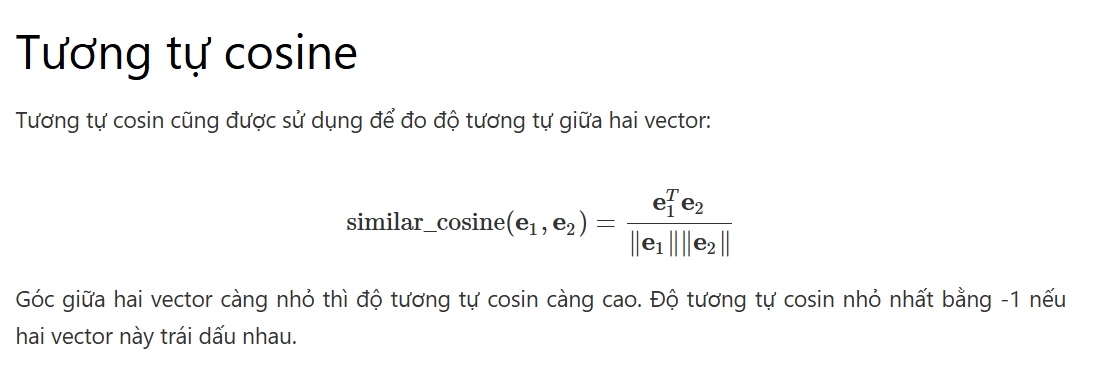

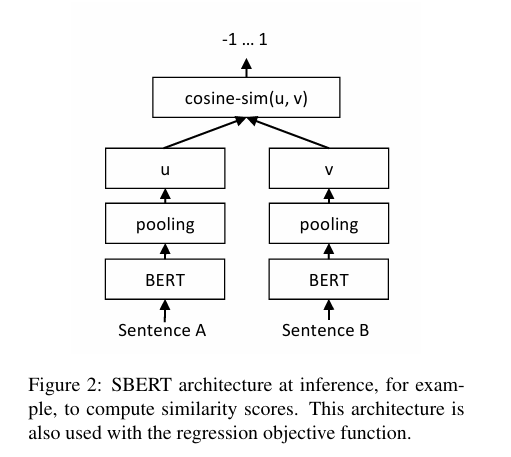

 **Regression Objective Function**. The cosine
similarity between the two sentence embeddings
 u and v is computed (Figure 2). We use **mean
squared-error loss** as the objective function.

In [27]:
class CosineSimilarityLoss(torch.nn.Module):

    def __init__(self,  loss_fct = torch.nn.MSELoss(), cos_score_transformation=torch.nn.Identity()):
      
        super(CosineSimilarityLoss, self).__init__()
        self.loss_fct = loss_fct
        self.cos_score_transformation = cos_score_transformation
        self.cos = torch.nn.CosineSimilarity(dim=1)


    def forward(self, input, label):

        embedding_1 = torch.stack([inp[0] for inp in input])
        embedding_2 = torch.stack([inp[1] for inp in input])

        output = self.cos_score_transformation(self.cos(embedding_1, embedding_2))

        return self.loss_fct(output, label.squeeze())

In [28]:
!pip install d2l

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.9/58.9 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 111.7/111.7 kB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 77.3 MB/s eta 0:00:00:00:01:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 70.8 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 84.3 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.6/62.6 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.4/34.4 MB 50.3 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.3/98.3 kB 8.0 MB/s eta 0:00:00
  Attempting uninstall: requests
    Found existing installation: requests 2.32.3
    Uninstalling requests-2.32.3:
      Successfully uninstalled requests-2.32.3
  Attempting uninstall: pyparsing
    Found existing installation: pyparsing 3.1.2
    Uninstalling pyparsing-3.1.2:
      Successfully uninstalled pyparsing-3.1.2

In [33]:
from torch.optim import Adam
from torch.utils.data import DataLoader
from tqdm import tqdm

def model_train(dataset, epochs, learning_rate, bs):

    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")

    model = STSBertModel()

    criterion = CosineSimilarityLoss()
    optimizer = Adam(model.parameters(), lr=learning_rate)

    train_dataset = DataSequence(dataset)
    train_dataloader = DataLoader(train_dataset, num_workers=4, batch_size=bs, shuffle=True)

    if use_cuda:
        model = model.cuda()
        criterion = criterion.cuda()

    best_acc = 0.0
    best_loss = 1000

    for i in range(epochs):

        total_acc_train = 0
        total_loss_train = 0.0

        for train_data, train_label in tqdm(train_dataloader):

            train_data['input_ids'] = train_data['input_ids'].to(device)
            train_data['attention_mask'] = train_data['attention_mask'].to(device)
            del train_data['token_type_ids']

            train_data = collate_fn(train_data)

            output = [model(feature)['sentence_embedding'] for feature in train_data]

            loss = criterion(output, train_label.to(device))
            total_loss_train += loss.item()

            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        print(f'Epochs: {i + 1} | Loss: {total_loss_train / len(dataset): .3f}')
        model.train()

    return model

EPOCHS = 8
LEARNING_RATE = 1e-6
BATCH_SIZE = 8

# Train the model
trained_model = model_train(dataset, EPOCHS, LEARNING_RATE, BATCH_SIZE)

  0%|          | 0/719 [00:00<?, ?it/s]/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
100%|██████████| 719/719 [17:02<00:00,  1.27s/it]/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
100%|██████████| 719/719 [17:02<00:00,  1.42s/it]


Epochs: 1 | Loss:  0.009


100%|██████████| 719/719 [17:27<00:00,  1.46s/it]


Epochs: 2 | Loss:  0.004


100%|██████████| 719/719 [17:27<00:00,  1.46s/it]


Epochs: 3 | Loss:  0.004


100%|██████████| 719/719 [17:27<00:00,  1.46s/it]


Epochs: 4 | Loss:  0.003


100%|██████████| 719/719 [17:28<00:00,  1.46s/it]


Epochs: 5 | Loss:  0.003


100%|██████████| 719/719 [17:28<00:00,  1.46s/it]


Epochs: 6 | Loss:  0.003


100%|██████████| 719/719 [17:28<00:00,  1.46s/it]


Epochs: 7 | Loss:  0.003


100%|██████████| 719/719 [17:27<00:00,  1.46s/it]

Epochs: 8 | Loss:  0.002


https://readmedium.com/semantic-textual-similarity-with-bert-fc800656e7a3

xem thêm : https://readmedium.com/semantic-textual-similarity-83b3ca4a840e

https://readmedium.com/semantic-similarity-using-transformers-8f3cb5bf66d6

predict

In [34]:
# Load test data
test_dataset = load_dataset("stsb_multi_mt", name="en", split="test")

# Prepare test data
sentence_1_test = [i['sentence1'] for i in test_dataset]
sentence_2_test = [i['sentence2'] for i in test_dataset]
text_cat_test = [[str(x), str(y)] for x,y in zip(sentence_1_test, sentence_2_test)]

# Function to predict test data
def predict_sts(texts):

      trained_model.to('cpu')
      trained_model.eval()

      test_input = tokenizer(texts, padding='max_length', max_length = 128, truncation=True, return_tensors="pt")
      test_input['input_ids'] = test_input['input_ids']
      test_input['attention_mask'] = test_input['attention_mask']
      del test_input['token_type_ids']

      test_output = trained_model(test_input)['sentence_embedding']
      sim = torch.nn.functional.cosine_similarity(test_output[0], test_output[1], dim=0).item()

      return sim

In [38]:
print(text_cat_test[420])


['four children are playing on a trampoline.', 'Four kids are jumping on a trampoline.']


In [40]:
print(predict_sts(text_cat_test[420]))

0.8730202913284302


xem them source : https://github.com/marcellusruben/medium-resources/blob/main/STS_BERT/STS_BERT.ipynb

****## Single Text Classification using BERT

Overview Dataset CoLA

**Corpus of Linguistic Acceptability (CoLA)** là một tập dữ liệu sử dụng trong lĩnh vực xử lý ngôn ngữ tự nhiên (NLP) nhằm phân loại tính chấp nhận được về mặt ngữ pháp của một câu. Mỗi câu trong tập dữ liệu được đánh giá là **"chấp nhận được"** hoặc **"không chấp nhận được"** dựa trên cấu trúc ngữ pháp. CoLA được dùng phổ biến trong các bài toán phân loại văn bản đơn lẻ, nơi mô hình phải xác định xem một câu có hợp lệ về ngữ pháp hay không.

Tổng quan về CoLA:
- **Nguồn gốc**: Tập dữ liệu này được thu thập từ các bài báo ngôn ngữ học với các ví dụ câu, do các chuyên gia xác định mức độ chấp nhận ngữ pháp.
- **Nhiệm vụ chính**: Xác định một câu có phải là ngữ pháp hợp lệ hay không.
- **Kích thước tập dữ liệu**: CoLA chứa khoảng 10,000 câu, với nhãn "acceptable" hoặc "unacceptable".
- **Ứng dụng**: Được sử dụng rộng rãi trong các bài thi chuẩn hóa về NLP, như GLUE benchmark, để đánh giá hiệu quả của mô hình trong bài toán phân loại.

CoLA là một ví dụ điển hình về bài toán phân loại văn bản dựa trên tính đúng sai của ngữ pháp, giúp kiểm tra khả năng hiểu ngữ pháp của các mô hình ngôn ngữ.

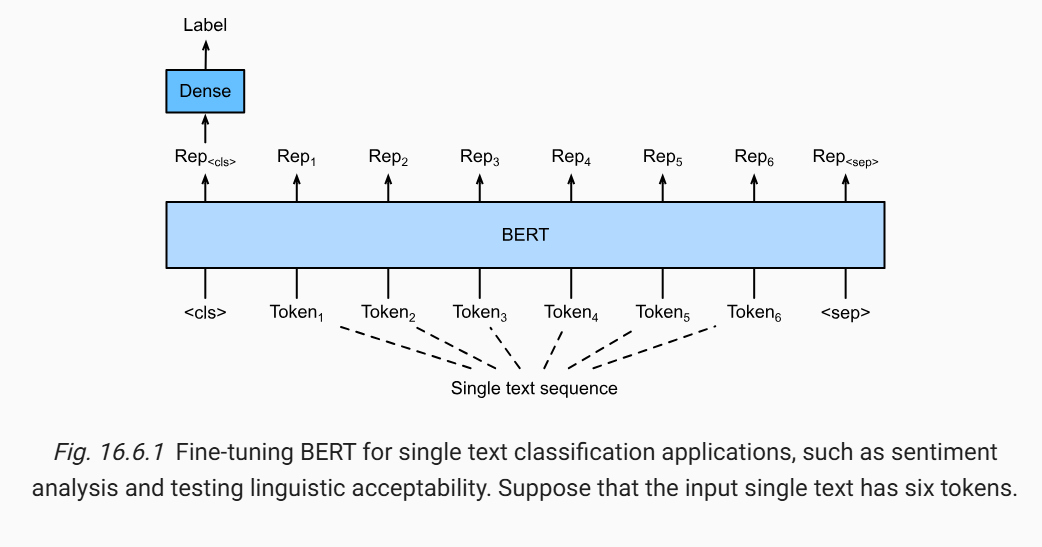

In [1]:
!pip install d2l

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.9/58.9 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 111.7/111.7 kB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 87.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 74.1 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 95.1 MB/s eta 0:00:00:00:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.6/62.6 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.4/34.4 MB 48.9 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.3/98.3 kB 7.5 MB/s eta 0:00:00
  Attempting uninstall: requests
    Found existing installation: requests 2.32.3
    Uninstalling requests-2.32.3:
      Successfully uninstalled requests-2.32.3
  Attempting uninstall: pyparsing
    Found existing installation: pyparsing 3.1.2
    Uninstalling pyparsing-3.1.2:
      Successfully uninstalled pyparsing-3.1.

In [2]:
import os 
import re 
import torch
from torch import nn
from d2l import torch as d2l

In [3]:
d2l.DATA_HUB['CoLA'] = ('https://dl.fbaipublicfiles.com/glue/data/CoLA.zip','unknown')

data_dir = d2l.download_extract('CoLA')

In [4]:
os.path.join(data_dir, 'train.tsv')

'../data/CoLA/train.tsv'

In [18]:
def read_data_CoLA(data_dir,is_train,is_dev):
    if is_train:
        file_name = os.path.join(data_dir, 'train.tsv')
    elif is_dev:
        file_name = os.path.join(data_dir, 'dev.tsv')
    else:
        file_name = os.path.join(data_dir, 'test.tsv')
    with open(file_name, 'r') as f:
          lines = [line.split('\t') for line in f.readlines()]
    def extract_text(s):
        s = re.sub('.\n','',s)
        s = re.sub(',','',s)
        return s
    tokens = [extract_text(line[-1]) for line in lines]
    labels = [line[1] for line in lines]
    return tokens, labels

In [20]:
data = read_data_CoLA(data_dir, is_train=True,is_dev=False)
import pandas as pd

dict = {'tokens':data[0], 'labels':data[1]}
df = pd.DataFrame(dict)

In [21]:
df.head()

tokens labels
0  Our friends won't buy this analysis let alone ...      1
1   One more pseudo generalization and I'm giving up      1
2    One more pseudo generalization or I'm giving up      1
3       The more we study verbs the crazier they get      1
4           Day by day the facts are getting murkier      1

In [17]:
len(df)

8551

In [106]:
data[0][:2]

["Our friends won't buy this analysis let alone the next one we propose",
 "One more pseudo generalization and I'm giving up"]

In [122]:
len_t = []
for i in data[0]:
    len_t.append(len(i))


In [123]:
max(len_t)

229

In [111]:
len(data_2[1])

549367

In [10]:
data_t = read_data_CoLA(data_dir,is_train=True)
all_sentence_tokens = [d2l.tokenize([s.lower() for s in data_t[0]])]
# print(all_sentence_tokens[])

In [11]:
import torch
import multiprocessing
from torch.utils.data import Dataset

class CoLABERTDataset(torch.utils.data.Dataset):
    def __init__(self, dataset, max_len, vocab=None):
        # Tokenize the sentences (CoLA only has one sentence per example)
        all_sentence_tokens = [d2l.tokenize([s.lower()]) for s in dataset[0]]
        
        # Labels for CoLA are binary (1/0)
        self.labels = torch.tensor(dataset[1], dtype=torch.long)
        self.vocab = vocab
        self.max_len = max_len
        
        # Preprocess the tokenized sentences
        self.all_token_ids, self.all_segments, self.valid_lens = self._preprocess(all_sentence_tokens)
        print('read ' + str(len(self.all_token_ids)) + ' examples')

    def _preprocess(self, all_sentence_tokens):
        pool = multiprocessing.Pool(4)  # Use 4 worker processes
        out = pool.map(self._mp_worker, all_sentence_tokens)
        
        # Unpack the results from multiprocessing
        all_token_ids = [token_ids for token_ids, segments, valid_len in out]
        all_segments = [segments for token_ids, segments, valid_len in out]
        valid_lens = [valid_len for token_ids, segments, valid_len in out]
        
        return (torch.tensor(all_token_ids, dtype=torch.long),
                torch.tensor(all_segments, dtype=torch.long),
                torch.tensor(valid_lens))

    def _mp_worker(self, sentence_tokens):
        tokens = sentence_tokens[0]
        # Add the BERT special tokens ('<CLS>' and '<SEP>')
        tokens = ['<CLS>'] + tokens + ['<SEP>']
        
        # Token IDs and padding
        token_ids = self.vocab[tokens] + [self.vocab['<pad>']] * (self.max_len - len(tokens))
        
        # Segments (CoLA has only one segment)
        segments = [0] * self.max_len
        
        # Valid length is the length of the actual tokens (excluding padding)
        valid_len = len(tokens)
        
        return token_ids, segments, valid_len

    def __getitem__(self, idx):
        # Return the token ids, segment ids, valid length, and the label
        return (self.all_token_ids[idx], self.all_segments[idx],
                self.valid_lens[idx]), self.labels[idx]

    def __len__(self):
        return len(self.all_token_ids)


Pretrained Model

In [12]:
import json
import multiprocessing

In [13]:
d2l.DATA_HUB['bert.base'] = (d2l.DATA_URL + 'bert.base.torch.zip',
                             '225d66f04cae318b841a13d32af3acc165f253ac')
d2l.DATA_HUB['bert.small'] = (d2l.DATA_URL + 'bert.small.torch.zip',
                              'c72329e68a732bef0452e4b96a1c341c8910f81f')

In [14]:
def load_pretrained_model(pretrained_model, num_hiddens, ffn_num_hiddens,
                          num_heads, num_blks, dropout, max_len, devices):
    data_dir = d2l.download_extract(pretrained_model)
    # Define an empty vocabulary to load the predefined vocabulary
    vocab = d2l.Vocab()
    vocab.idx_to_token = json.load(open(os.path.join(data_dir, 'vocab.json')))
    vocab.token_to_idx = {token: idx for idx, token in enumerate(
        vocab.idx_to_token)}
    bert = d2l.BERTModel(
        len(vocab), num_hiddens, ffn_num_hiddens=ffn_num_hiddens, num_heads=4,
        num_blks=2, dropout=0.2, max_len=max_len)
    # Load pretrained BERT parameters
    bert.load_state_dict(torch.load(os.path.join(data_dir,
                                                 'pretrained.params')))
    return bert, vocab

In [15]:
devices = d2l.try_all_gpus()
bert, vocab = load_pretrained_model(
    'bert.small', num_hiddens=256, ffn_num_hiddens=512, num_heads=4,
    num_blks=2, dropout=0.1, max_len=512, devices=devices)

/tmp/ipykernel_30/325226183.py:13: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  bert.load_state_dict(torch.load(os.path.join(data_dir,


In [16]:
# Reduce `batch_size` if there is an out of memory error. In the original BERT
# model, `max_len` = 512
batch_size, max_len, num_workers = 128, 60, d2l.get_dataloader_workers()
data_dir = d2l.download_extract('CoLA')
train_set = CoLABERTDataset(read_data_CoLA(data_dir,is_train=True), max_len, vocab)
test_set = CoLABERTDataset(read_data_CoLA(data_dir, is_train=False), max_len, vocab)
train_iter = torch.utils.data.DataLoader(train_set, batch_size, shuffle=True,
                                   num_workers=num_workers)
test_iter = torch.utils.data.DataLoader(test_set, batch_size,
                                  num_workers=num_workers)

read 8551 examples
read 527 examples


In [17]:
class BERTClassifier(nn.Module):
    def __init__(self, bert):
        super(BERTClassifier, self).__init__()
        self.encoder = bert.encoder
        self.hidden = bert.hidden
        self.output = nn.LazyLinear(2)

    def forward(self, inputs):
        tokens_X, segments_X, valid_lens_x = inputs
        encoded_X = self.encoder(tokens_X, segments_X, valid_lens_x)
        return self.output(self.hidden(encoded_X[:, 0, :]))
    # self.hidden(encoded_X[:, 0, :]): Trích xuất vector [CLS] từ encoded_X cho toàn bộ câu (vị trí đầu tiên) và đưa qua lớp hidden.

In [18]:
net = BERTClassifier(bert)

loss 0.505, train acc 0.742, test acc 0.679
3347.1 examples/sec on [device(type='cuda', index=0), device(type='cuda', index=1)]


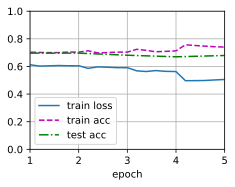

In [19]:
lr, num_epochs = 1e-4, 5
trainer = torch.optim.Adam(net.parameters(), lr=lr)
loss = nn.CrossEntropyLoss(reduction='none')
net(next(iter(train_iter))[0])
d2l.train_ch13(net, train_iter, test_iter, loss, trainer, num_epochs, devices)

In [1]:
import pandas as pd

dict = {'tokens':data[0], 'labels':data[1]}
df = pd.DataFrame(dict)
df.head()

NameError: name 'data' is not defined

In [33]:
df['labels'][:1]

0    1
Name: labels, dtype: int64

In [22]:
from transformers import BertTokenizer, BertModel
import numpy as np

In [23]:
tokenizer = BertTokenizer.from_pretrained('bert-base-cased')

class Dataset(torch.utils.data.Dataset):

    def __init__(self, df):

        self.labels = [label for label in df['labels']]
        self.texts = [tokenizer(text, 
                               padding='max_length', max_length = 512, truncation=True,
                                return_tensors="pt") for text in df['tokens']]

    def classes(self):
        return self.labels

    def __len__(self):
        return len(self.labels)

    def get_batch_labels(self, idx):
        # Fetch a batch of labels
        return np.array(self.labels[idx])

    def get_batch_texts(self, idx):
        # Fetch a batch of inputs
        return self.texts[idx]

    def __getitem__(self, idx):

        batch_texts = self.get_batch_texts(idx)
        batch_y = self.get_batch_labels(idx)

        return batch_texts, batch_y
class BertClassifier(nn.Module):

    def __init__(self, dropout=0.5):

        super(BertClassifier, self).__init__()

        self.bert = BertModel.from_pretrained('bert-base-cased')
        self.dropout = nn.Dropout(dropout)
        self.linear = nn.Linear(768, 5)
        self.relu = nn.ReLU()

    def forward(self, input_id, mask):

        _, pooled_output = self.bert(input_ids= input_id, attention_mask=mask,return_dict=False)
        dropout_output = self.dropout(pooled_output)
        linear_output = self.linear(dropout_output)
        final_layer = self.relu(linear_output)

        return final_layer
def train(model, train_data, val_data, learning_rate, epochs):

    train, val = Dataset(train_data), Dataset(val_data)

    train_dataloader = torch.utils.data.DataLoader(train, batch_size=2, shuffle=True)
    val_dataloader = torch.utils.data.DataLoader(val, batch_size=2)

    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")

    criterion = nn.CrossEntropyLoss()
    optimizer = Adam(model.parameters(), lr= learning_rate)

    if use_cuda:

            model = model.cuda()
            criterion = criterion.cuda()

    for epoch_num in range(epochs):

            total_acc_train = 0
            total_loss_train = 0

            for train_input, train_label in tqdm(train_dataloader):

                train_label = train_label.to(device)
                mask = train_input['attention_mask'].to(device)
                input_id = train_input['input_ids'].squeeze(1).to(device)

                output = model(input_id, mask)
                
                batch_loss = criterion(output, train_label.long())
                total_loss_train += batch_loss.item()
                
                acc = (output.argmax(dim=1) == train_label).sum().item()
                total_acc_train += acc

                model.zero_grad()
                batch_loss.backward()
                optimizer.step()
            
            total_acc_val = 0
            total_loss_val = 0

            with torch.no_grad():

                for val_input, val_label in val_dataloader:

                    val_label = val_label.to(device)
                    mask = val_input['attention_mask'].to(device)
                    input_id = val_input['input_ids'].squeeze(1).to(device)

                    output = model(input_id, mask)

                    batch_loss = criterion(output, val_label.long())
                    total_loss_val += batch_loss.item()
                    
                    acc = (output.argmax(dim=1) == val_label).sum().item()
                    total_acc_val += acc
            
            print(
                f'Epochs: {epoch_num + 1} | Train Loss: {total_loss_train / len(train_data): .3f} | Train Accuracy: {total_acc_train / len(train_data): .3f} | Val Loss: {total_loss_val / len(val_data): .3f} | Val Accuracy: {total_acc_val / len(val_data): .3f}')
                  
def evaluate(model, test_data):

    test = Dataset(test_data)

    test_dataloader = torch.utils.data.DataLoader(test, batch_size=2)

    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")

    if use_cuda:

        model = model.cuda()

    total_acc_test = 0
    with torch.no_grad():

        for test_input, test_label in test_dataloader:

              test_label = test_label.to(device)
              mask = test_input['attention_mask'].to(device)
              input_id = test_input['input_ids'].squeeze(1).to(device)

              output = model(input_id, mask)

              acc = (output.argmax(dim=1) == test_label).sum().item()
              total_acc_test += acc
    
    print(f'Test Accuracy: {total_acc_test / len(test_data): .3f}')


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [37]:
def read_data_CoLA(data_dir,is_train,is_dev):
    if is_train:
        file_name = os.path.join(data_dir, 'train.tsv')
    elif is_dev:
        file_name = os.path.join(data_dir, 'dev.tsv')
    with open(file_name, 'r') as f:
          lines = [line.split('\t') for line in f.readlines()]
    def extract_text(s):
        s = re.sub('.\n','',s)
        s = re.sub(',','',s)
        return s
    tokens = [extract_text(line[-1]) for line in lines]
    labels = [int(line[1]) for line in lines]
    return tokens, labels

In [51]:
def read_data_CoLA_test(data_dir):
    file_name = os.path.join(data_dir, 'test.tsv')
    with open(file_name, 'r') as f:
          lines = [line.split('\t') for line in f.readlines()]
    def extract_text(s):
        s = re.sub('.\n','',s)
        s = re.sub(',','',s)
        return s
    sentences = [extract_text(line[1]) for line in lines]
    return sentences[1:]

In [64]:
def read_data_CoLA_test_1(data_dir):
    file_name = os.path.join(data_dir,'original','raw','out_of_domain_dev.tsv')
    with open(file_name, 'r') as f:
          lines = [line.split('\t') for line in f.readlines()]
    def extract_text(s):
        s = re.sub('.\n','',s)
        s = re.sub(',','',s)
        return s
    tokens = [extract_text(line[-1]) for line in lines]
    labels = [int(line[1]) for line in lines]
    return tokens, labels

In [52]:
data_test = read_data_CoLA_test(data_dir)

In [54]:
data_test[:3]

['Bill whistled past the house',
 'The car honked its way down the road',
 'Bill pushed Harry off the sofa']

In [55]:
import pandas as pd
data_train = read_data_CoLA(data_dir, is_train=True,is_dev=False)
data_dev = read_data_CoLA(data_dir, is_train=False, is_dev=True)
data_test = read_data_CoLA_test(data_dir)

dict_train = {'tokens':data_train[0], 'labels':data_train[1]}
df_train = pd.DataFrame(dict_train)

dict_dev = {'tokens':data_dev[0], 'labels':data_dev[1]}
df_dev = pd.DataFrame(dict_dev)


dict_test = {'sentence':data_test}
df_test = pd.DataFrame(dict_test)


In [65]:
data_test_1 = read_data_CoLA_test_1(data_dir)
dict_test_1 = {'tokens':data_test_1[0], 'labels':data_test_1[1]}
df_test_1 = pd.DataFrame(dict_test_1)

In [66]:
df_test_1.head()

tokens  labels
0                     Somebody just left - guess who       1
1  They claimed they had settled on something but...       1
2            If Sam was going Sally would know where       1
3  They're going to serve the guests something bu...       1
4                She's reading. I can't imagine what       1

In [59]:
df_dev.head()

tokens  labels
0     The sailors rode the breeze clear of the rocks       1
1  The weights made the rope stretch over the pulley       1
2          The mechanical doll wriggled itself loose       1
3          If you had eaten more you would want less       1
4             As you eat the most you want the least       0

In [60]:
df_train.head()

tokens  labels
0  Our friends won't buy this analysis let alone ...       1
1   One more pseudo generalization and I'm giving up       1
2    One more pseudo generalization or I'm giving up       1
3       The more we study verbs the crazier they get       1
4           Day by day the facts are getting murkier       1

In [61]:
import pandas as pd
import torch
import numpy as np
from transformers import BertTokenizer, BertModel
from torch import nn
from torch.optim import Adam
from tqdm import tqdm
np.random.seed(112)


df_train, df_val, df_test = df_train, df_dev, df_test

print(len(df_train),len(df_val), len(df_test))
EPOCHS = 5
model = BertClassifier()
LR = 1e-6
              
train(model, df_train, df_val, LR, EPOCHS)
evaluate(model, df_test)

8551 1043 1063


model.safetensors:   0%|          | 0.00/436M [00:00<?, ?B/s]

100%|██████████| 4276/4276 [14:48<00:00,  4.81it/s]


Epochs: 1 | Train Loss:  0.500 | Train Accuracy:  0.683 | Val Loss:  0.370 | Val Accuracy:  0.686


100%|██████████| 4276/4276 [14:51<00:00,  4.80it/s]


Epochs: 2 | Train Loss:  0.272 | Train Accuracy:  0.757 | Val Loss:  0.258 | Val Accuracy:  0.767


100%|██████████| 4276/4276 [14:51<00:00,  4.80it/s]


Epochs: 3 | Train Loss:  0.185 | Train Accuracy:  0.858 | Val Loss:  0.246 | Val Accuracy:  0.772


100%|██████████| 4276/4276 [14:51<00:00,  4.80it/s]


Epochs: 4 | Train Loss:  0.118 | Train Accuracy:  0.924 | Val Loss:  0.283 | Val Accuracy:  0.779


100%|██████████| 4276/4276 [14:51<00:00,  4.80it/s]


Epochs: 5 | Train Loss:  0.073 | Train Accuracy:  0.955 | Val Loss:  0.316 | Val Accuracy:  0.770


KeyError: 'labels'

In [67]:
evaluate(model, df_test_1)

Test Accuracy:  0.746


## Text tagging 

Text tagging (hay gán nhãn văn bản) trong xử lý ngôn ngữ tự nhiên (NLP) là quá trình gán nhãn hoặc danh mục cho các từ, cụm từ, hoặc đoạn văn bản dựa trên một số quy tắc hoặc thuật toán nhất định. Dưới đây là một cái nhìn tổng quan về các loại text tagging phổ biến trong NLP:

 1. **Part-of-Speech (POS) Tagging**:
   - **Mục tiêu**: Gán nhãn loại từ (danh từ, động từ, tính từ, trạng từ, v.v.) cho từng từ trong một câu.
   - **Ứng dụng**: Cung cấp thông tin về ngữ pháp để hỗ trợ các nhiệm vụ khác như phân tích cú pháp, dịch máy, hoặc nhận diện thực thể.

 2. **Named Entity Recognition (NER)**:
   - **Mục tiêu**: Xác định và gán nhãn các thực thể tên riêng như tên người, địa điểm, tổ chức, ngày tháng, v.v.
   - **Ứng dụng**: Phân tích văn bản, trích xuất thông tin, hệ thống hỏi đáp, và hệ thống chatbot.

 3. **Chunking (Shallow Parsing)**:
   - **Mục tiêu**: Xác định các nhóm từ tạo thành các đơn vị cú pháp như cụm danh từ (NP), cụm động từ (VP), cụm giới từ (PP), v.v.
   - **Ứng dụng**: Hiểu ngữ nghĩa, phân tích cú pháp bề mặt.

 4. **Sentiment Tagging**:
   - **Mục tiêu**: Gán nhãn cảm xúc hoặc thái độ (tích cực, tiêu cực, trung lập) cho các đoạn văn bản hoặc câu.
   - **Ứng dụng**: Phân tích cảm xúc, phân tích ý kiến, nghiên cứu thị trường.

 5. **Semantic Role Labeling (SRL)**:
   - **Mục tiêu**: Gán nhãn các vai trò ngữ nghĩa mà các từ hoặc cụm từ đảm nhận trong câu (ai làm gì, với ai, khi nào).
   - **Ứng dụng**: Phân tích ngữ nghĩa sâu, hệ thống hỏi đáp.

 6. **Text Classification**:
   - **Mục tiêu**: Gán nhãn cho toàn bộ văn bản vào các danh mục như thể loại, chủ đề, hay nhãn cảm xúc.
   - **Ứng dụng**: Phân loại email, tin tức, lọc spam, phân tích chủ đề.

 7. **Intent Tagging**:
   - **Mục tiêu**: Xác định và gán nhãn mục đích của người dùng trong các câu thoại hoặc đoạn văn bản (như hỏi thông tin, đặt lệnh, yêu cầu dịch vụ).
   - **Ứng dụng**: Chatbot, hệ thống trợ lý ảo.

 Ứng dụng của Text Tagging:
   - Tự động hóa xử lý văn bản như tóm tắt, dịch ngôn ngữ.
   - Phân tích dữ liệu khách hàng, phản hồi từ người dùng.
   - Phát triển chatbot thông minh hoặc các hệ thống hỏi đáp.
   - Hỗ trợ các ứng dụng hiểu ngữ cảnh trong trợ lý ảo (như Google Assistant, Siri).

Text tagging đóng vai trò quan trọng trong việc làm giàu thông tin ngữ nghĩa và cú pháp cho các mô hình NLP hiện đại.

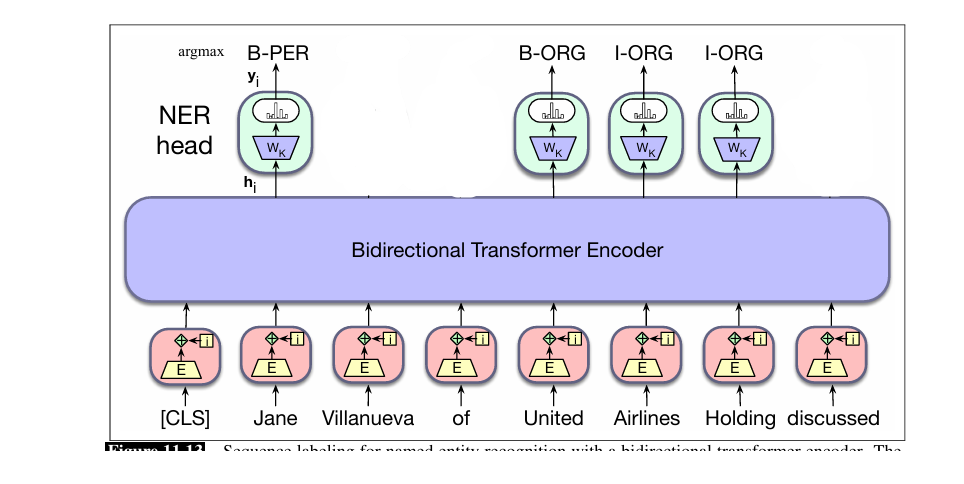

Build Named Entity Recognizer 

https://www.kaggle.com/code/muhammadshoaibsarwar/how-to-import-data-from-google-drive

In [1]:
!pip install d2l

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.9/58.9 kB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 111.7/111.7 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 78.0 MB/s eta 0:00:00:00:01:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 72.2 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 84.2 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.6/62.6 kB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.4/34.4 MB 46.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.3/98.3 kB 8.5 MB/s eta 0:00:00
  Attempting uninstall: requests
    Found existing installation: requests 2.32.3
    Uninstalling requests-2.32.3:
      Successfully uninstalled requests-2.32.3
  Attempting uninstall: pyparsing
    Found existing installation: pyparsing 3.1.2
    Uninstalling pyparsing-3.1.2:
      Successfully uninstalled pyparsing-3.1.2

In [2]:
import json
import multiprocessing
import os
import torch
from torch import nn
from d2l import torch as d2l

In [4]:
d2l.DATA_HUB['bert.base'] = (d2l.DATA_URL + 'bert.base.torch.zip',
                             '225d66f04cae318b841a13d32af3acc165f253ac')
d2l.DATA_HUB['bert.small'] = (d2l.DATA_URL + 'bert.small.torch.zip',
                              'c72329e68a732bef0452e4b96a1c341c8910f81f')

In [5]:
def load_pretrained_model(pretrained_model, num_hiddens, ffn_num_hiddens,
                          num_heads, num_blks, dropout, max_len, devices):
    data_dir = d2l.download_extract(pretrained_model)
    # Define an empty vocabulary to load the predefined vocabulary
    vocab = d2l.Vocab()
    vocab.idx_to_token = json.load(open(os.path.join(data_dir, 'vocab.json')))
    vocab.token_to_idx = {token: idx for idx, token in enumerate(
        vocab.idx_to_token)}
    bert = d2l.BERTModel(
        len(vocab), num_hiddens, ffn_num_hiddens=ffn_num_hiddens, num_heads=4,
        num_blks=2, dropout=0.2, max_len=max_len)
    # Load pretrained BERT parameters
    bert.load_state_dict(torch.load(os.path.join(data_dir,
                                                 'pretrained.params')))
    return bert, vocab

In [11]:
devices = d2l.try_all_gpus()
bert, vocab = load_pretrained_model(
    'bert.small', num_hiddens=256, ffn_num_hiddens=512, num_heads=4,
    num_blks=2, dropout=0.1, max_len=512, devices=devices)

/tmp/ipykernel_30/325226183.py:13: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  bert.load_state_dict(torch.load(os.path.join(data_dir,


In [12]:
import requests
url = "https://raw.githubusercontent.com/juand-r/entity-recognition-datasets/master/data/wikigold/CONLL-format/data/wikigold.conll.txt"

def load_data_CONLL(data_dir,is_train):
    response = requests.get(url)
    contents = response.text
    contents = contents.replace('\n',' ')
    contents = contents.split('. O')
    contents= [content.split() for content in contents]
    texts = [content[::2] for content in contents]
    labels = [content[1::2] for content in contents]
    texts = [' '.join(text) for text in texts]
    labels = [' '.join(label) for label in labels]
    if is_train:
        texts = texts[:int(len(texts)*0.8)]
        labels = labels[:int(len(labels)*0.8)]
    else:
        texts = texts[int(len(texts)*0.8):]
        labels = labels[int(len(labels)*0.8):]
    return texts, labels
dataset = load_data_CONLL(url,is_train=True)

In [16]:
!pip install transformers


In [26]:
import torch
import multiprocessing
from torch.utils.data import Dataset
label_all_tokens = False

def align_label(texts, labels):
    tokenized_inputs = [d2l.tokenize([s.lower()]) for s in texts]

    word_ids = tokenized_inputs.word_ids()

    previous_word_idx = None
    label_ids = []

    for word_idx in word_ids:

        if word_idx is None:
            label_ids.append(-100)

        elif word_idx != previous_word_idx:
            try:
                label_ids.append(labels_to_ids[labels[word_idx]])
            except:
                label_ids.append(-100)
        else:
            try:
                label_ids.append(labels_to_ids[labels[word_idx]] if label_all_tokens else -100)
            except:
                label_ids.append(-100)
        previous_word_idx = word_idx

    return label_ids

class CONLLBERTDataset(torch.utils.data.Dataset):
    def __init__(self, dataset, max_len, vocab=None):
        # Tokenize the sentences (CoLA only has one sentence per example)
        all_sentence_tokens = [d2l.tokenize([s.lower()]) for s in dataset[0]]
        self.labels = [i.split() for i in dataset[1]]
        self.vocab = vocab
        self.max_len = max_len
        
        # Preprocess the tokenized sentences
        self.all_token_ids, self.all_segments, self.valid_lens = self._preprocess(all_sentence_tokens)
        print('read ' + str(len(self.all_token_ids)) + ' examples')

    def _preprocess(self, all_sentence_tokens):
        pool = multiprocessing.Pool(4)  # Use 4 worker processes
        out = pool.map(self._mp_worker, all_sentence_tokens)
        
        # Unpack the results from multiprocessing
        all_token_ids = [token_ids for token_ids, segments, valid_len in out]
        all_segments = [segments for token_ids, segments, valid_len in out]
        valid_lens = [valid_len for token_ids, segments, valid_len in out]
        
        return (torch.tensor(all_token_ids, dtype=torch.long),
                torch.tensor(all_segments, dtype=torch.long),
                torch.tensor(valid_lens))
    def _mp_worker(self, sentence_tokens):
        # Get the tokenized input IDs as a list
        tokens = sentence_tokens['input_ids'].squeeze(0).tolist()
        
        # Add the BERT special tokens ('<CLS>' and '<SEP>')
        tokens = [self.vocab['<CLS>']] + tokens + [self.vocab['<SEP>']]
    def _mp_worker(self, sentence_tokens):
        tokens = sentence_tokens[0]
        # Add the BERT special tokens ('<CLS>' and '<SEP>')
        tokens = ['<CLS>'] + tokens + ['<SEP>']
        
        # Token IDs and padding
        token_ids = self.vocab[tokens] + [self.vocab['<pad>']] * (self.max_len - len(tokens))
        
        # Segments (CONLL has only one segment)
        segments = [0] * self.max_len
        
        # Valid length is the length of the actual tokens (excluding padding)
        valid_len = len(tokens)
        
        return token_ids, segments, valid_len

    def __getitem__(self, idx):
        # Return the token ids, segment ids, valid length, and the label
        return (self.all_token_ids[idx], self.all_segments[idx],
                self.valid_lens[idx]), self.labels[idx]

    def __len__(self):
        return len(self.all_token_ids)


In [39]:
# Reduce `batch_size` if there is an out of memory error. In the original BERT
# model, `max_len` = 512
batch_size, max_len, num_workers = 64, 200, d2l.get_dataloader_workers()
url = "https://raw.githubusercontent.com/juand-r/entity-recognition-datasets/master/data/wikigold/CONLL-format/data/wikigold.conll.txt"
data_dir = url
train_set = CONLLBERTDataset(load_data_CONLL(data_dir,is_train=True), max_len, vocab)
test_set = CONLLBERTDataset(load_data_CONLL(data_dir, is_train=False), max_len, vocab)
train_iter = torch.utils.data.DataLoader(train_set, batch_size, shuffle=True,
                                   num_workers=num_workers)
test_iter = torch.utils.data.DataLoader(test_set, batch_size,
                                  num_workers=num_workers)

read 1347 examples
read 337 examples


In [28]:
class BERTTextTagging_NER(torch.nn.Module):
    def __init__(self, bert, num_labels):
        super(BERTTextTagging_NER, self).__init__()
        self.encoder = bert.encoder
        self.hidden = bert.hidden
        self.output = nn.LazyLinear(ma)

    def forward(self, inputs):
        tokens_X, segments_X, valid_lens_x = inputs
        encoded_X = self.encoder(tokens_X, segments_X, valid_lens_x)
        return self.output(self.hidden(encoded_X[:, 1:-1, :]))

In [40]:
net = BERTTextTagging_NER(bert, max_len-2)
lr, num_epochs = 1e-4, 5
trainer = torch.optim.Adam(net.parameters(), lr=lr)
loss = nn.CrossEntropyLoss(reduction='none')
net(next(iter(train_iter))[0])
d2l.train_ch13(net, train_iter, test_iter, loss, trainer, num_epochs, devices)

RuntimeError: Caught RuntimeError in DataLoader worker process 0.
Original Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/worker.py", line 309, in _worker_loop
    data = fetcher.fetch(index)  # type: ignore[possibly-undefined]
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/fetch.py", line 55, in fetch
    return self.collate_fn(data)
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py", line 317, in default_collate
    return collate(batch, collate_fn_map=default_collate_fn_map)
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py", line 174, in collate
    return [collate(samples, collate_fn_map=collate_fn_map) for samples in transposed]  # Backwards compatibility.
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py", line 174, in <listcomp>
    return [collate(samples, collate_fn_map=collate_fn_map) for samples in transposed]  # Backwards compatibility.
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py", line 170, in collate
    raise RuntimeError('each element in list of batch should be of equal size')
RuntimeError: each element in list of batch should be of equal size


## Question Answering

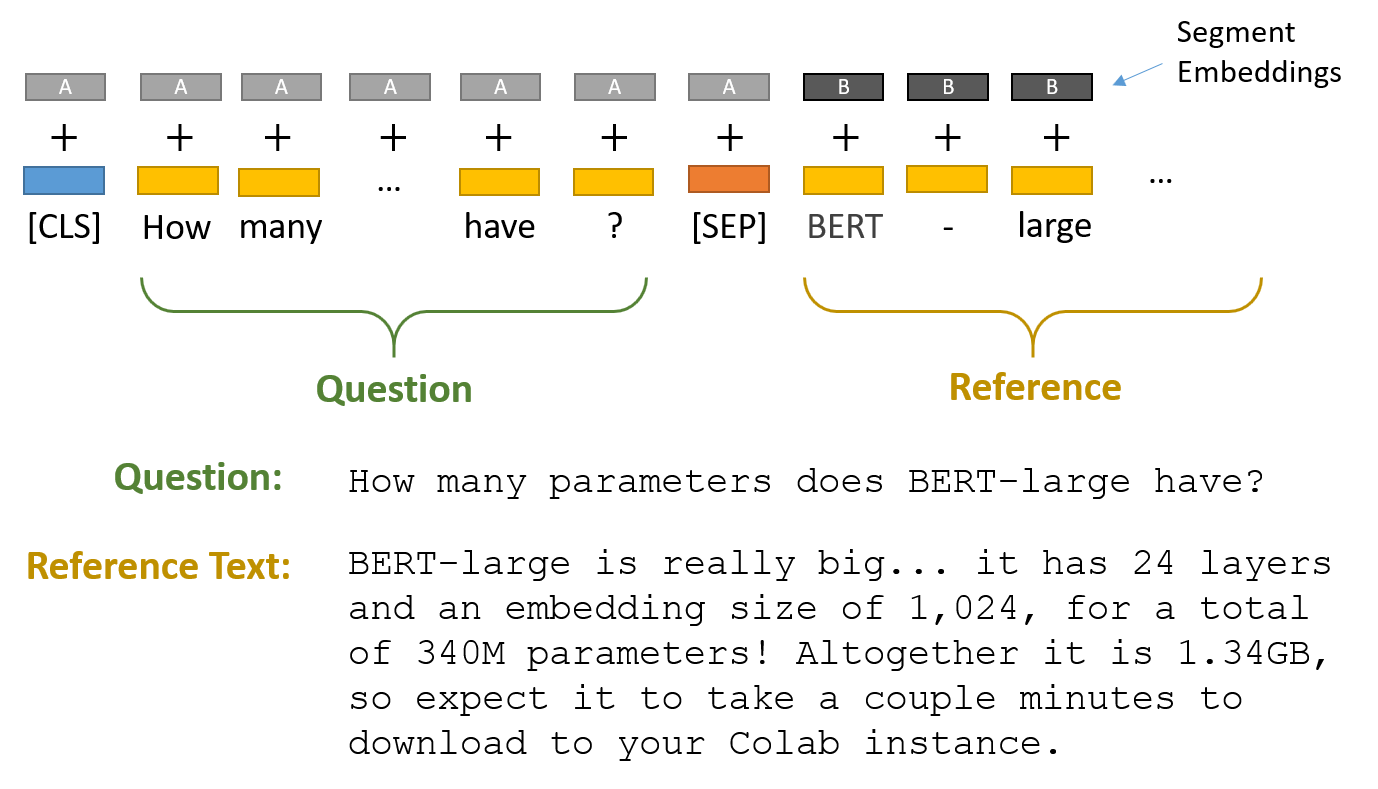

Start & End Token Classifiers

![Start token classification](http://www.mccormickml.com/assets/BERT/SQuAD/start_token_classification.png)

![End token classification](http://www.mccormickml.com/assets/BERT/SQuAD/end_token_classification.png)

In [1]:
import pandas as pd

df = pd.read_csv('/kaggle/input/squad-v11/SQuAD-v1.1.csv')

In [90]:
df.head()

title  \
0  University_of_Notre_Dame   
1  University_of_Notre_Dame   
2  University_of_Notre_Dame   
3  University_of_Notre_Dame   
4  University_of_Notre_Dame   

                                             context  \
0  Architecturally, the school has a Catholic cha...   
1  Architecturally, the school has a Catholic cha...   
2  Architecturally, the school has a Catholic cha...   
3  Architecturally, the school has a Catholic cha...   
4  Architecturally, the school has a Catholic cha...   

                                            question  \
0  To whom did the Virgin Mary allegedly appear i...   
1  What is in front of the Notre Dame Main Building?   
2  The Basilica of the Sacred heart at Notre Dame...   
3                  What is the Grotto at Notre Dame?   
4  What sits on top of the Main Building at Notre...   

                                    answer  answer_start  answer_end  
0               Saint Bernadette Soubirous           515         541  
1                a copper statue of Christ           188         213  
2                        the Main Building           279         296  
3  a Marian place of prayer and reflection           381         420  
4       a golden statue of the Virgin Mary            92         126

Initialize Tokenizer

In [3]:
import torch
from transformers import BertTokenizerFast

In [4]:
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Data set for fune tuning Question Answering

The way Question Answering working : https://www.kaggle.com/code/thedrcat/question-answering-tutorial

dựa trên https://huggingface.co/docs/transformers/tasks/question_answering#train

In [5]:
def pre_texts(question, context):
    tokenized_question = tokenizer(question, padding='max_length', max_length=512, truncation=True)
    tokenized_context = tokenizer(context, padding='max_length', max_length=512, truncation=True)
    
    # Remove <cls> token from context
    tokenized_context = {key: value[1:] for key, value in tokenized_context.items()}
    
    # Combine question and context
    tokenized_combined = {key: value + tokenized_context[key] for key, value in tokenized_question.items()}
    
    return tokenized_combined
tokenized = pre_texts(df['question'][0], df['context'][0])

In [6]:
import torch
import pandas as pd
from transformers import AutoTokenizer

class DatasetforQuestionAnswering(torch.utils.data.Dataset):
    def __init__(self, dataframe, tokenizer_checkpoint="bert-base-cased", max_length=384, stride=128):
        self.tokenizer = AutoTokenizer.from_pretrained(tokenizer_checkpoint)
        self.dataframe = dataframe
        self.max_length = max_length
        self.stride = stride

        # Prepare the dataset by adding answer_start and answer_end
        self.dataframe = self.dataframe.apply(self.prepare_data, axis=1)

    def prepare_data(self, example):
        answer = str(example["answer"])
        example["answer_start"] = example["answer_start"]
        example["answer_end"] = example["answer_start"] + len(answer)
        return example

    def find_labels(self, offsets, answer_start, answer_end, sequence_ids):
        idx = 0
        while sequence_ids[idx] != 1:
            idx += 1
        context_start = idx
        while sequence_ids[idx] == 1:
            idx += 1
        context_end = idx - 1

        # If the answer is not fully in the context, return (0, 0)
        if offsets[context_start][0] > answer_end or offsets[context_end][1] < answer_start:
            return (0, 0)
        else:
            idx = context_start
            while idx <= context_end and offsets[idx][0] <= answer_start:
                idx += 1
            start_position = idx - 1

            idx = context_end
            while idx >= context_start and offsets[idx][1] >= answer_end:
                idx -= 1
            end_position = idx + 1
        
            return start_position, end_position

    def preprocess_example(self, example):
        inputs = self.tokenizer(
            example["question"],
            example["context"],
            truncation="only_second",
            padding="max_length",
            max_length=self.max_length,
            stride=self.stride,
            return_overflowing_tokens=True,
            return_offsets_mapping=True,
        )

        offset_mapping = inputs.pop("offset_mapping")
        sample_map = inputs.pop("overflow_to_sample_mapping")
        inputs["start_positions"] = []
        inputs["end_positions"] = []

        for i, offset in enumerate(offset_mapping):
            sample_idx = sample_map[i]
            start, end = self.find_labels(
                offset, example["answer_start"], example["answer_end"], inputs.sequence_ids(i)
            )
            
            inputs["start_positions"].append(start)
            inputs["end_positions"].append(end)

        return inputs

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        example = self.dataframe.iloc[idx]  # Access row from DataFrame
        inputs = self.preprocess_example(example)
        return {
            "input_ids": torch.tensor(inputs["input_ids"][0], dtype=torch.long),
            "attention_mask": torch.tensor(inputs["attention_mask"][0], dtype=torch.long),
            "start_positions": torch.tensor(inputs["start_positions"], dtype=torch.long),
            "end_positions": torch.tensor(inputs["end_positions"], dtype=torch.long)
        }

In [7]:
# Load and use the class
qa_dataset = DatasetforQuestionAnswering(df)
data_loader = torch.utils.data.DataLoader(qa_dataset, batch_size=8, shuffle=True)


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

In [9]:
from transformers import BertForQuestionAnswering

class BertModelQA(torch.nn.Module):
    def __init__(self):
        super(BertModelQA, self).__init__()
        # Question Answering
        self.bert = BertForQuestionAnswering.from_pretrained('bert-base-cased')

    def forward(self, input_id, mask, start_positions=None, end_positions=None):
        output = self.bert(input_ids=input_id, 
                           attention_mask=mask, 
                           start_positions=start_positions, 
                           end_positions=end_positions)
        return output


In [11]:
def train_loop(model, df_train, df_val):
    train_dataset = DatasetforQuestionAnswering(df_train)
    val_dataset = DatasetforQuestionAnswering(df_val)

    train_dataloader = DataLoader(train_dataset, num_workers=4, batch_size=BATCH_SIZE, shuffle=True)
    val_dataloader = DataLoader(val_dataset, num_workers=4, batch_size=BATCH_SIZE)

    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")

    optimizer = SGD(model.parameters(), lr=LEARNING_RATE)

    if use_cuda:
        model = model.cuda()

    best_acc = 0
    best_loss = 1000

    for epoch_num in range(EPOCHS):
        total_acc_train = 0
        total_loss_train = 0

        model.train()

        for train_data in tqdm(train_dataloader):
            # Chuẩn bị các đầu vào cho mô hình
            start_positions = train_data['start_positions'].to(device)
            end_positions = train_data['end_positions'].to(device)
            mask = train_data['attention_mask'].squeeze(1).to(device)
            input_id = train_data['input_ids'].squeeze(1).to(device)

            optimizer.zero_grad()

            # Tính loss và logits cho cả start và end
            outputs = model(input_id, mask, start_positions, end_positions)
            loss = outputs.loss
            start_logits = outputs.start_logits
            end_logits = outputs.end_logits

            total_loss_train += loss.item()

            # Dự đoán vị trí bắt đầu và kết thúc
            start_preds = start_logits.argmax(dim=1)
            end_preds = end_logits.argmax(dim=1)

            # Tính độ chính xác (accuracy) khi cả start và end đều đúng
            acc = ((start_preds == start_positions) & (end_preds == end_positions)).float().mean()
            total_acc_train += acc

            loss.backward()
            optimizer.step()

        model.eval()

        total_acc_val = 0
        total_loss_val = 0

        for val_data in val_dataloader:
            # Chuẩn bị các đầu vào cho mô hình
            start_positions = val_data['start_positions'].to(device)
            end_positions = val_data['end_positions'].to(device)
            mask = val_data['attention_mask'].squeeze(1).to(device)
            input_id = val_data['input_ids'].squeeze(1).to(device)

            # Không tính gradient trong quá trình validation
            with torch.no_grad():
                outputs = model(input_id, mask, start_positions, end_positions)
                loss = outputs.loss
                start_logits = outputs.start_logits
                end_logits = outputs.end_logits

            total_loss_val += loss.item()

            # Dự đoán vị trí bắt đầu và kết thúc
            start_preds = start_logits.argmax(dim=1)
            end_preds = end_logits.argmax(dim=1)

            # Tính độ chính xác (accuracy) khi cả start và end đều đúng
            acc = ((start_preds == start_positions) & (end_preds == end_positions)).float().mean()
            total_acc_val += acc

        # Tính toán và in kết quả
        val_accuracy = total_acc_val / len(df_val)
        val_loss = total_loss_val / len(df_val)

        print(
            f'Epochs: {epoch_num + 1} | Loss: {total_loss_train / len(df_train): .3f} | '
            f'Accuracy: {total_acc_train / len(df_train): .3f} | '
            f'Val_Loss: {val_loss: .3f} | Val_Accuracy: {val_accuracy: .3f}'
        )

# Thông số cấu hình


In [13]:
import numpy as np
from tqdm import tqdm
from torch.optim import SGD
from torch.utils.data import DataLoader

np.random.seed(112)
df_train, df_val, df_test = np.split(df.sample(frac=1, random_state=42), 
                                     [int(.8*len(df)), int(.9*len(df))])

print(len(df_train),len(df_val), len(df_test))

70079 8760 8760


/opt/conda/lib/python3.10/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


In [14]:
LEARNING_RATE = 5e-3
EPOCHS = 5
BATCH_SIZE = 2

model = BertModelQA()
train_loop(model, df_train, df_val)

Some weights of BertForQuestionAnswering were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['qa_outputs.bias', 'qa_outputs.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https:

RuntimeError: Caught RuntimeError in DataLoader worker process 0.
Original Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/worker.py", line 309, in _worker_loop
    data = fetcher.fetch(index)  # type: ignore[possibly-undefined]
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/fetch.py", line 55, in fetch
    return self.collate_fn(data)
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py", line 317, in default_collate
    return collate(batch, collate_fn_map=default_collate_fn_map)
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py", line 155, in collate
    clone.update({key: collate([d[key] for d in batch], collate_fn_map=collate_fn_map) for key in elem})
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py", line 155, in <dictcomp>
    clone.update({key: collate([d[key] for d in batch], collate_fn_map=collate_fn_map) for key in elem})
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py", line 142, in collate
    return collate_fn_map[elem_type](batch, collate_fn_map=collate_fn_map)
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py", line 213, in collate_tensor_fn
    out = elem.new(storage).resize_(len(batch), *list(elem.size()))
RuntimeError: Trying to resize storage that is not resizable


## Summarization for T5

Overview T5 (Text-To-Text Transfer Transformer)

Architecture T5 :  Transformer encoder-decoder used pre-traing, T5 is different from BERT (used encoder), GPT (decoder)

https://cameronrwolfe.substack.com/p/t5-text-to-text-transformers-part

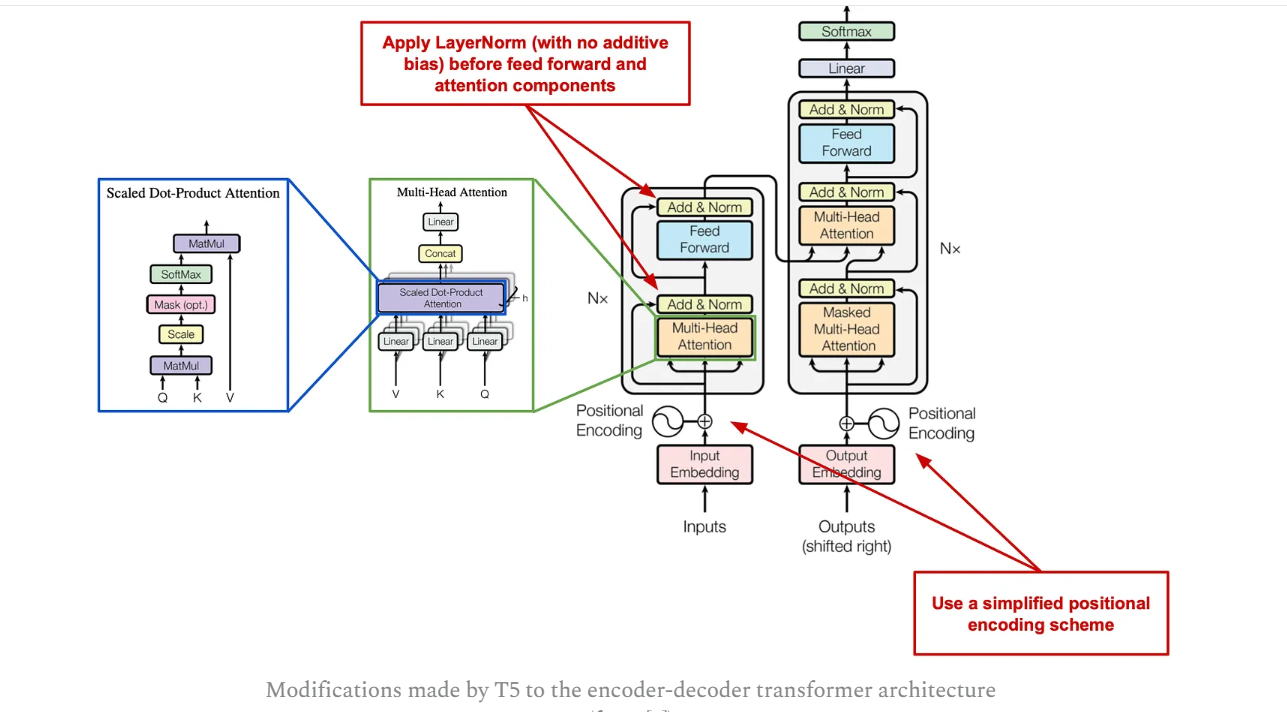

Giống như kiến trúc Transformers nhưng nó có một vài tinh chỉnh.

LayerNorm is applied immediately before each attention and feed forward transformation (i.e., outside of the residual path)

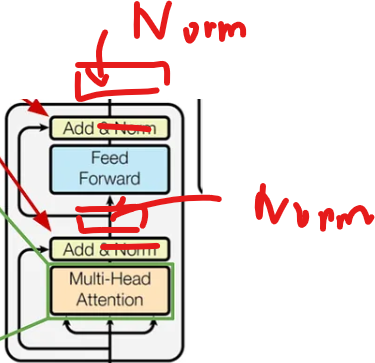

No additive bias is used for LayerNorm (i.e., see here; we only use scale and eliminate the additive bias)
torch.nn.LayerNorm(normalized_shape, eps=1e-05, elementwise_affine=True, bias=False, device=None, dtype=None) khởi tạo bias = False 
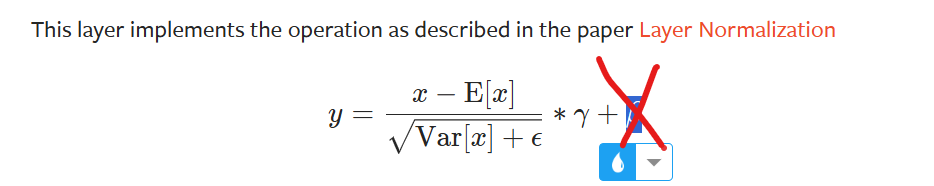

A simple position embedding scheme is used that adds a scalar to the corresponding logit used to compute attention weights

Sử dụng các embedding khác thay vì sử dụng position embeddding, xem thêm các relative position embeddings, rotate embedding 

Dropout is applied throughout the network (e.g., attention weights, feed forward network, skip connection, etc.)

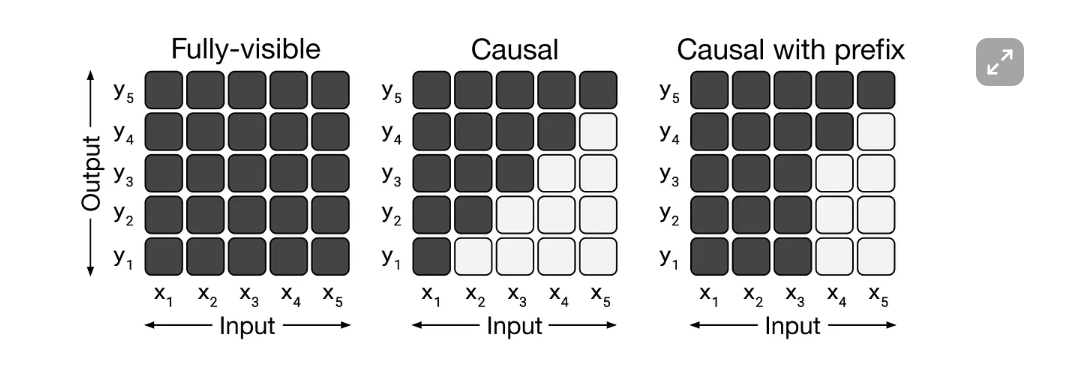

So với các kiến trúc encoder-decoder, các mô hình chỉ dùng decoder bị hạn chế vì chúng chỉ sử dụng attention nhân quả (causal) hay còn gọi là self-attention có mặt nạ. Self-attention có mặt nạ chỉ xem xét các token trước đó khi tính toán biểu diễn cho một token bất kỳ trong chuỗi. Tuy nhiên, có một số trường hợp chúng ta muốn thực hiện attention toàn bộ (fully-visible) trên một đoạn văn bản ban đầu hoặc tiền tố, sau đó tạo đầu ra dựa trên tiền tố này (ví dụ như các tác vụ dịch thuật). Các mô hình chỉ dùng decoder không thể xử lý được các trường hợp như vậy, vì chúng thực hiện attention nhân quả trên toàn bộ đầu vào.

Tiền tố: "Dịch từ tiếng Anh sang tiếng Pháp:"

Đầu vào: "The weather is nice today."

Kết quả: "Le temps est agréable aujourd'hui."

Một kỹ thuật unsupervised mới được gọi là : masked span prediction

Inspired by the MLM objective from BERT, T5 is pre-trained using a slightly modified denoising objective that: [Lấy cảm hứng từ mục tiêu MLM từ BERT, T5 được đào tạo trước bằng cách sử dụng mục tiêu khử nhiễu được sửa đổi một chút:] x

Randomly selects 15% of tokens in the input sequence [Chọn ngẫu nhiên 15% mã thông báo trong chuỗi đầu vào] x

Replaces all consecutive spans of selected tokens with a single
”sentinel” token [Thay thế tất cả các khoảng liên tiếp của mã thông báo đã chọn bằng một mã thông báo "sentinel" duy nhất] x

Gives each sentinel token an ID that is unique to the current input sequence [Cung cấp cho mỗi mã thông báo trọng điểm một ID duy nhất cho chuỗi đầu vào hiện tại] x

Constructs a target using all selected tokens, separated by the sentinel tokens [Tạo mục tiêu bằng cách sử dụng tất cả các mã thông báo đã chọn, được phân tách bằng mã thông báo trọng điểm] x
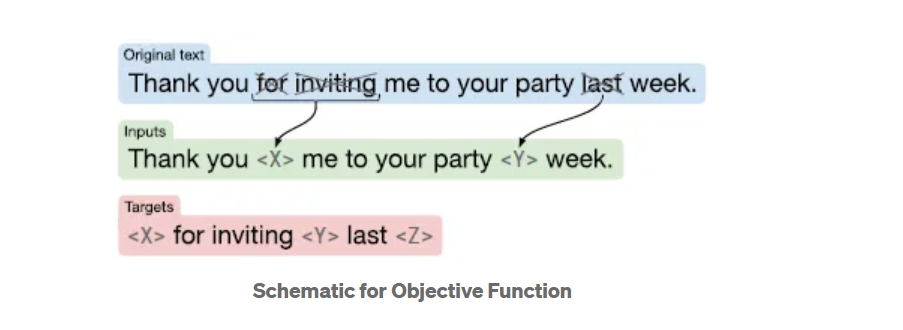
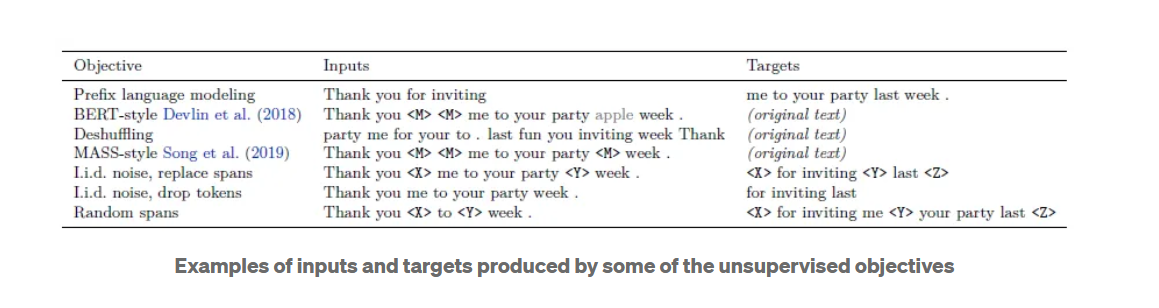

  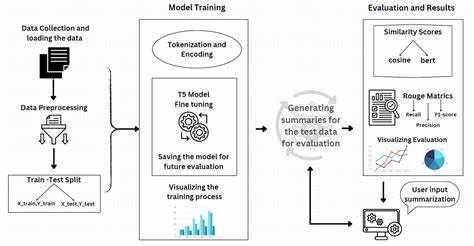

In [1]:
!pip install transformers

In [19]:
import pandas as pd

df = pd.read_csv('/kaggle/input/newspaper-text-summarization-cnn-dailymail/cnn_dailymail/train.csv')

In [3]:
df.head()

id  \
0  0001d1afc246a7964130f43ae940af6bc6c57f01   
1  0002095e55fcbd3a2f366d9bf92a95433dc305ef   
2  00027e965c8264c35cc1bc55556db388da82b07f   
3  0002c17436637c4fe1837c935c04de47adb18e9a   
4  0003ad6ef0c37534f80b55b4235108024b407f0b   

                                             article  \
0  By . Associated Press . PUBLISHED: . 14:11 EST...   
1  (CNN) -- Ralph Mata was an internal affairs li...   
2  A drunk driver who killed a young woman in a h...   
3  (CNN) -- With a breezy sweep of his pen Presid...   
4  Fleetwood are the only team still to have a 10...   

                                          highlights  
0  Bishop John Folda, of North Dakota, is taking ...  
1  Criminal complaint: Cop used his role to help ...  
2  Craig Eccleston-Todd, 27, had drunk at least t...  
3  Nina dos Santos says Europe must be ready to a...  
4  Fleetwood top of League One after 2-0 win at S...

https://huggingface.co/docs/transformers/tasks/summarization

https://github.com/huggingface/transformers/blob/main/src/transformers/models/t5/modeling_t5.py

 Positionwise Feed-Forward Networks

In [1]:
!pip install transformers

dataset

In [2]:
import torch
from torch import nn
import os
import re
import pandas as pd
import numpy as np

In [3]:
df = pd.read_csv('/kaggle/input/newspaper-text-summarization-cnn-dailymail/cnn_dailymail/train.csv')

In [16]:
df.head()

id  \
0  0001d1afc246a7964130f43ae940af6bc6c57f01   
1  0002095e55fcbd3a2f366d9bf92a95433dc305ef   
2  00027e965c8264c35cc1bc55556db388da82b07f   
3  0002c17436637c4fe1837c935c04de47adb18e9a   
4  0003ad6ef0c37534f80b55b4235108024b407f0b   

                                             article  \
0  By . Associated Press . PUBLISHED: . 14:11 EST...   
1  (CNN) -- Ralph Mata was an internal affairs li...   
2  A drunk driver who killed a young woman in a h...   
3  (CNN) -- With a breezy sweep of his pen Presid...   
4  Fleetwood are the only team still to have a 10...   

                                          highlights  
0  Bishop John Folda, of North Dakota, is taking ...  
1  Criminal complaint: Cop used his role to help ...  
2  Craig Eccleston-Todd, 27, had drunk at least t...  
3  Nina dos Santos says Europe must be ready to a...  
4  Fleetwood top of League One after 2-0 win at S...

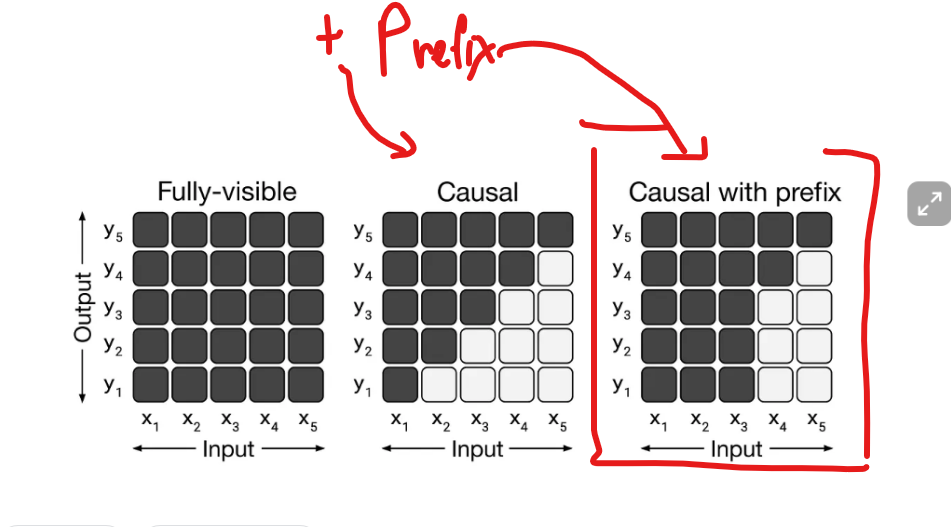

Add Prefix from 

In [4]:
data_dir = '/kaggle/input/newspaper-text-summarization-cnn-dailymail/cnn_dailymail'
prefix = 'summarize'
def read_cnn_dailymail(data_dir, is_train, is_dev):
    if is_train:
        data_dir = os.path.join(data_dir, 'train.csv')
    elif is_dev:
        data_dir = os.path.join(data_dir, 'validation.csv')
    else:
        data_dir = os.path.join(data_dir, 'test.csv')
    dataset = pd.read_csv(data_dir)
    contexts = [prefix + text for text in dataset['article']]
    labels = dataset['highlights']
    return contexts, labels

In [5]:
df_train = read_cnn_dailymail(data_dir, is_train=True, is_dev=False)
df_val = read_cnn_dailymail(data_dir, is_train=False, is_dev=True)

In [6]:
import torch
from torch.utils.data import DataLoader
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer
from tqdm import tqdm

class CNNDMDataset(torch.utils.data.Dataset):
    def __init__(self, dataset, tokenizer, max_length=512):
        self.contexts = tokenizer(dataset[0], max_length=max_length, truncation=True, padding='max_length', return_tensors='pt')
        # Convert labels to list of strings before tokenization
        self.labels = tokenizer([str(label) for label in dataset[1]], max_length=512, truncation=True, padding='max_length', return_tensors='pt')
        # Extract the input_ids from the tokenized labels and convert to a tensor
        self.labels = self.labels['input_ids']

    def __len__(self):
        return len(self.contexts['input_ids'])

    def __getitem__(self, idx):
        return {
            'input_ids': self.contexts['input_ids'][idx],
            'attention_mask': self.contexts['attention_mask'][idx],
            'labels': self.labels[idx] # Return the label tensor
        }


In [7]:
class T5forsummarize(torch.nn.Module):
    def __init__(self):
        super(T5forsummarize, self).__init__()
        checkpoint = "google-t5/t5-small"  # Chỉnh sửa checkpoint tùy vào phiên bản bạn cần
        self.T5 = AutoModelForSeq2SeqLM.from_pretrained(checkpoint)

    def forward(self, input_id, mask, labels):
        outputs = self.T5(input_ids=input_id, attention_mask=mask, labels=labels, return_dict=False)
        loss = outputs[0]
        logits = outputs[1]
        return loss, logits

In [8]:
def train_loop(model, df_train, df_val, tokenizer):
    train_dataset = CNNDMDataset(df_train, tokenizer)
    val_dataset = CNNDMDataset(df_val, tokenizer)

    train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

    for epoch in range(EPOCHS):
        model.train()
        total_loss_train = 0

        for batch in tqdm(train_dataloader):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            optimizer.zero_grad()
            loss, _ = model(input_ids, attention_mask, labels)
            loss.backward()
            optimizer.step()

            total_loss_train += loss.item()

        model.eval()
        total_loss_val = 0

        with torch.no_grad():
            for batch in val_dataloader:
                input_ids = batch['input_ids'].to(device)
                attention_mask = batch['attention_mask'].to(device)
                labels = batch['labels'].to(device)

                loss, _ = model(input_ids, attention_mask, labels)
                total_loss_val += loss.item()

        print(f"Epoch {epoch + 1}/{EPOCHS}")
        print(f"Train Loss: {total_loss_train / len(train_dataloader)}")
        print(f"Val Loss: {total_loss_val / len(val_dataloader)}")

LEARNING_RATE = 5e-3
EPOCHS = 5
BATCH_SIZE = 2

# Khởi tạo mô hình và tokenizer
checkpoint = 'google-t5/t5-small'
tokenizer = AutoTokenizer.from_pretrained(checkpoint)
model = T5forsummarize()



tokenizer_config.json:   0%|          | 0.00/2.32k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.21k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/242M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

In [ ]:
train_loop(model, df_train, df_val, tokenizer)

In [ ]:
import evaluate

rouge = evaluate.load("rouge")

In [ ]:
df_test = 

In [ ]:
import numpy as np
import evaluate

rouge = evaluate.load("rouge")

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    decoded_preds = tokenizer.batch_decode(predictions, skip_special_tokens=True)
    labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)

    result = rouge.compute(predictions=decoded_preds, references=decoded_labels, use_stemmer=True)

    prediction_lens = [np.count_nonzero(pred != tokenizer.pad_token_id) for pred in predictions]
    result["gen_len"] = np.mean(prediction_lens)

    return {k: round(v, 4) for k, v in result.items()}